### Repeated Prisioner's Dilemma
#### Double Agent w/o discounting or state
- There are two agents that interact in repeated prisioner's dilemma. 
- Actions are: defect (D/0) or cooperate (C/1).
- Defect is dominant strategy, and (D,D) is Nash Eqbm of stage game. 
- Sustained Cooperation is best for everyone in repeated game. 
- Rewards for agents are 

    - (1,1) for (D,D) 
    - (3,0) for (D,C) 
    - (0,3) for (C,D) 
    - (2.5,2.5) for (C,C)

- There is just one state that does not change. State does not play a role here, it is just a placeholder. 
- There is no "discounting". Agents only value current profits - they do not seek to maximize discounted sum. 

### Import Packages

In [13]:
from itertools import count
import torch
import math
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams['font.size']=20

### Helper Functions

In [15]:
def gameReward(a1,a2):
    if (a1 == 0 and a2 == 0): # DD
        return (1,1)
    if (a1 == 0 and a2 == 1): # DC
        return (3,0)
    if (a1 == 1 and a2 == 0): # CD
        return (0,3)
    if (a1 == 1 and a2 == 1): # CC
        return (2.5,2.5)
    
import random
from collections import namedtuple, deque
Transition = namedtuple('Transition',('state','next_state','a1','a2','r1','r2'))

class ReplayMemory(object):
    # Holds transitions from experience and gives a random batch of transitions for training
    def __init__(self,capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self,*args):
        "save transition"
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    # Input: State
    # Output: 0,1
    # Network is going to try to predict the expected Return of taking each action given the INPUT
    def __init__(self, n_obs, n_actions):
        super(DQN,self).__init__()
        self.layer1 = nn.Linear(n_obs, 128)
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128, n_actions)
    
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)   


def select_action(state, policy_net, idx):
    # Given state selects action either from the DQN or randomly. 
    global steps_done1, steps_done2
    sample = random.random()
    if idx == 0:
        eps_threshold = EPS_END + (EPS_START-EPS_END)*math.exp(-1.*steps_done1/EPS_DECAY)
        steps_done1 += 1
    else:
        eps_threshold = EPS_END + (EPS_START-EPS_END)*math.exp(-1.*steps_done2/EPS_DECAY)
        steps_done2 += 1
    
    if sample>eps_threshold:
        with torch.no_grad():
            try: 
                return policy_net(state).max(1)[1].view(1,1) # pick up action with largest expected reward
            except:
                return policy_net(state).max(0)[1].view(1,1) # pick up action with largest expected reward
    else:
        randchoice = random.choice([0,1])
        return torch.tensor([[randchoice]],dtype=torch.long)
    
def update_target_net(target_net, policy_net):
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*TAU+target_net_state_dict[key]*(1-TAU)
    target_net.load_state_dict(target_net_state_dict)

def optimize_model(policy_net,target_net,idx):
    if len(memory)<BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    # final state is after simulation is done
    # these are the "s(t+1)" from the transitions
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    # we begin with a batch of transitions - (state, action, reward)
    state_batch = torch.cat(batch.state)
    if idx == 0:
        action_batch = torch.cat(batch.a1)
        reward_batch = torch.cat(batch.r1)
    elif idx == 1:
        action_batch = torch.cat(batch.a2)
        reward_batch = torch.cat(batch.r2)
    
    # For these batch states we compute optimal policy according to our policy-network
    # Compute Q(s,a) and get actions - these are the actions that would have been taken for each batch state 
    state_action_values = policy_net(state_batch.reshape(-1,1)).gather(1,action_batch)
    
    # Compute V(s_t+1)
    next_state_values = torch.zeros(BATCH_SIZE)
    with torch.no_grad():
        # Use the "old" target_net to obtain value (Expected Return) on optimal actions from sampled s(t+1)
        # This is Q_old(s',a')
        next_state_values[non_final_mask] = target_net(non_final_next_states.reshape(-1,1)).max(1)[0]
        
    # Here we have add r + max Q_old(s',a')
    expected_state_action_values = (next_state_values*GAMMA)+reward_batch

    # Compute the loss
    # Q_new(s,a) - r + max Q_old(s',a'): is the error
    # Huber loss function
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values,expected_state_action_values.unsqueeze(1))
    if idx == 0:
        optimizer1.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(policy_net1.parameters(),100)
        optimizer1.step()
    elif idx == 1:
        optimizer2.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(policy_net2.parameters(),100)
        optimizer2.step()
    print(f'Loss Agent{idx}:{loss.item()}')

### HyperParameters and Initializations

In [21]:
BATCH_SIZE = 128 # number of transitions sampled from replay buffer
GAMMA = 0 # Discount factor
EPS_START = 0.9 # Initial value of Epsilon
EPS_END = 0.05 # End value of Epsilon
EPS_DECAY = 1000 # controls decay rate of Epsilon
TAU = 0.005 # update rate of target network
LR = 1e-4 # Learning rate of Adam
n_obs = 1
n_actions = 2
policy_net1 = DQN(n_obs,n_actions)
target_net1 = DQN(n_obs,n_actions)
policy_net2 = DQN(n_obs,n_actions)
target_net2 = DQN(n_obs,n_actions)
steps_done1 = 0
steps_done2 = 0
optimizer1 = optim.AdamW(policy_net1.parameters(),lr=LR,amsgrad=True)
optimizer2 = optim.AdamW(policy_net2.parameters(),lr=LR,amsgrad=True)
memory=ReplayMemory(10000)

### Training Loop

In [22]:
state = torch.tensor(1,dtype=torch.float32).unsqueeze(0)
actions = []
epochs = 10000
for t in range(epochs):
    print('\n Iteration:',t)
    # Take action
    a1 = select_action(state, policy_net1, 0)
    a2 = select_action(state, policy_net2, 1)

    # Obtain Rewards
    r1, r2 = gameReward(int(a1),int(a2))
    r1 = torch.tensor([r1])
    r2 = torch.tensor([r2])

    # Compute next state
    next_state = torch.tensor(1,dtype=torch.float32).unsqueeze(0)

    # store memory in transition
    memory.push(state,next_state,a1,a2,r1,r2)

    # move to next state
    state = next_state

    # optimize
    optimize_model(policy_net1,target_net1, 0)
    optimize_model(policy_net2,target_net2, 1)

    # soft update target_net
    update_target_net(target_net1, policy_net1)
    update_target_net(target_net2, policy_net2)
    
    # record actions
    actions.append([a1.item(),a2.item()])


 Iteration: 0

 Iteration: 1

 Iteration: 2

 Iteration: 3

 Iteration: 4

 Iteration: 5

 Iteration: 6

 Iteration: 7

 Iteration: 8

 Iteration: 9

 Iteration: 10

 Iteration: 11

 Iteration: 12

 Iteration: 13

 Iteration: 14

 Iteration: 15

 Iteration: 16

 Iteration: 17

 Iteration: 18

 Iteration: 19

 Iteration: 20

 Iteration: 21

 Iteration: 22

 Iteration: 23

 Iteration: 24

 Iteration: 25

 Iteration: 26

 Iteration: 27

 Iteration: 28

 Iteration: 29

 Iteration: 30

 Iteration: 31

 Iteration: 32

 Iteration: 33

 Iteration: 34

 Iteration: 35

 Iteration: 36

 Iteration: 37

 Iteration: 38

 Iteration: 39

 Iteration: 40

 Iteration: 41

 Iteration: 42

 Iteration: 43

 Iteration: 44

 Iteration: 45

 Iteration: 46

 Iteration: 47

 Iteration: 48

 Iteration: 49

 Iteration: 50

 Iteration: 51

 Iteration: 52

 Iteration: 53

 Iteration: 54

 Iteration: 55

 Iteration: 56

 Iteration: 57

 Iteration: 58

 Iteration: 59

 Iteration: 60

 Iteration: 61

 Iteration: 62

 

Loss Agent0:0.7024969458580017
Loss Agent1:0.5910111665725708

 Iteration: 208
Loss Agent0:0.7716339230537415
Loss Agent1:0.6443057656288147

 Iteration: 209
Loss Agent0:0.740922212600708
Loss Agent1:0.5141953825950623

 Iteration: 210
Loss Agent0:0.7202507257461548
Loss Agent1:0.6352640986442566

 Iteration: 211
Loss Agent0:0.7604762315750122
Loss Agent1:0.6086426973342896

 Iteration: 212
Loss Agent0:0.7508820295333862
Loss Agent1:0.608872652053833

 Iteration: 213
Loss Agent0:0.8064806461334229
Loss Agent1:0.6349117159843445

 Iteration: 214
Loss Agent0:0.7374119162559509
Loss Agent1:0.5698686838150024

 Iteration: 215
Loss Agent0:0.7077400088310242
Loss Agent1:0.6044600605964661

 Iteration: 216
Loss Agent0:0.6713563203811646
Loss Agent1:0.6604140400886536

 Iteration: 217
Loss Agent0:0.7353793382644653
Loss Agent1:0.6542234420776367

 Iteration: 218
Loss Agent0:0.7665024995803833
Loss Agent1:0.6010721325874329

 Iteration: 219
Loss Agent0:0.7470216155052185
Loss Agent1:0.626721680

Loss Agent0:0.4682021737098694
Loss Agent1:0.5486840605735779

 Iteration: 312
Loss Agent0:0.5113632678985596
Loss Agent1:0.5167973041534424

 Iteration: 313
Loss Agent0:0.6314817667007446
Loss Agent1:0.5830252170562744

 Iteration: 314
Loss Agent0:0.5226196646690369
Loss Agent1:0.5279785990715027

 Iteration: 315
Loss Agent0:0.4508235454559326
Loss Agent1:0.5165547728538513

 Iteration: 316
Loss Agent0:0.5145681500434875
Loss Agent1:0.5780702829360962

 Iteration: 317
Loss Agent0:0.5604780912399292
Loss Agent1:0.5604183673858643

 Iteration: 318
Loss Agent0:0.5162098407745361
Loss Agent1:0.5144922733306885

 Iteration: 319
Loss Agent0:0.4478985667228699
Loss Agent1:0.5358296036720276

 Iteration: 320
Loss Agent0:0.49441421031951904
Loss Agent1:0.4929002523422241

 Iteration: 321
Loss Agent0:0.579657793045044
Loss Agent1:0.5785442590713501

 Iteration: 322
Loss Agent0:0.4950622618198395
Loss Agent1:0.48597437143325806

 Iteration: 323
Loss Agent0:0.5166558027267456
Loss Agent1:0.424038

Loss Agent1:0.5357714891433716

 Iteration: 417
Loss Agent0:0.5050563812255859
Loss Agent1:0.5228679180145264

 Iteration: 418
Loss Agent0:0.44570258259773254
Loss Agent1:0.5444610118865967

 Iteration: 419
Loss Agent0:0.5053203105926514
Loss Agent1:0.4990540146827698

 Iteration: 420
Loss Agent0:0.5202294588088989
Loss Agent1:0.5487582087516785

 Iteration: 421
Loss Agent0:0.5305341482162476
Loss Agent1:0.47517675161361694

 Iteration: 422
Loss Agent0:0.4481908679008484
Loss Agent1:0.5221768617630005

 Iteration: 423
Loss Agent0:0.5266387462615967
Loss Agent1:0.46537449955940247

 Iteration: 424
Loss Agent0:0.5142378807067871
Loss Agent1:0.5423814058303833

 Iteration: 425
Loss Agent0:0.4989508092403412
Loss Agent1:0.5486098527908325

 Iteration: 426
Loss Agent0:0.48555788397789
Loss Agent1:0.475129634141922

 Iteration: 427
Loss Agent0:0.4473083019256592
Loss Agent1:0.5138094425201416

 Iteration: 428
Loss Agent0:0.5123008489608765
Loss Agent1:0.5108736753463745

 Iteration: 429
Loss

Loss Agent1:0.4699013829231262

 Iteration: 526
Loss Agent0:0.471126914024353
Loss Agent1:0.4974946081638336

 Iteration: 527
Loss Agent0:0.48565584421157837
Loss Agent1:0.5377821326255798

 Iteration: 528
Loss Agent0:0.4922058582305908
Loss Agent1:0.5082470178604126

 Iteration: 529
Loss Agent0:0.38040977716445923
Loss Agent1:0.5173057913780212

 Iteration: 530
Loss Agent0:0.45420578122138977
Loss Agent1:0.5129793882369995

 Iteration: 531
Loss Agent0:0.465198814868927
Loss Agent1:0.5150129199028015

 Iteration: 532
Loss Agent0:0.5399600267410278
Loss Agent1:0.4896145462989807

 Iteration: 533
Loss Agent0:0.474520742893219
Loss Agent1:0.4800206422805786

 Iteration: 534
Loss Agent0:0.4844386875629425
Loss Agent1:0.508647084236145

 Iteration: 535
Loss Agent0:0.4443950653076172
Loss Agent1:0.47600236535072327

 Iteration: 536
Loss Agent0:0.45885980129241943
Loss Agent1:0.4849415123462677

 Iteration: 537
Loss Agent0:0.5168402791023254
Loss Agent1:0.4479314684867859

 Iteration: 538
Los

Loss Agent0:0.4625072479248047
Loss Agent1:0.45652592182159424

 Iteration: 639
Loss Agent0:0.46446892619132996
Loss Agent1:0.5065534710884094

 Iteration: 640
Loss Agent0:0.5273613333702087
Loss Agent1:0.46936142444610596

 Iteration: 641
Loss Agent0:0.41858598589897156
Loss Agent1:0.4746537506580353

 Iteration: 642
Loss Agent0:0.5068484544754028
Loss Agent1:0.5218956470489502

 Iteration: 643
Loss Agent0:0.5026701092720032
Loss Agent1:0.48444777727127075

 Iteration: 644
Loss Agent0:0.5566158294677734
Loss Agent1:0.5073755383491516

 Iteration: 645
Loss Agent0:0.47536492347717285
Loss Agent1:0.553702175617218

 Iteration: 646
Loss Agent0:0.5289256572723389
Loss Agent1:0.45115453004837036

 Iteration: 647
Loss Agent0:0.5469953417778015
Loss Agent1:0.4830123782157898

 Iteration: 648
Loss Agent0:0.43778008222579956
Loss Agent1:0.46923211216926575

 Iteration: 649
Loss Agent0:0.47771328687667847
Loss Agent1:0.5324535965919495

 Iteration: 650
Loss Agent0:0.47588592767715454
Loss Agent1


 Iteration: 749
Loss Agent0:0.4804908335208893
Loss Agent1:0.5061615109443665

 Iteration: 750
Loss Agent0:0.4432283341884613
Loss Agent1:0.4846295416355133

 Iteration: 751
Loss Agent0:0.5644202828407288
Loss Agent1:0.45885854959487915

 Iteration: 752
Loss Agent0:0.4717361330986023
Loss Agent1:0.41760489344596863

 Iteration: 753
Loss Agent0:0.4775412380695343
Loss Agent1:0.5222738981246948

 Iteration: 754
Loss Agent0:0.3689345419406891
Loss Agent1:0.5302253365516663

 Iteration: 755
Loss Agent0:0.4214685559272766
Loss Agent1:0.4894847273826599

 Iteration: 756
Loss Agent0:0.515654444694519
Loss Agent1:0.4725341796875

 Iteration: 757
Loss Agent0:0.49036428332328796
Loss Agent1:0.5132831335067749

 Iteration: 758
Loss Agent0:0.4426097273826599
Loss Agent1:0.5184504389762878

 Iteration: 759
Loss Agent0:0.4415484666824341
Loss Agent1:0.49647659063339233

 Iteration: 760
Loss Agent0:0.47194963693618774
Loss Agent1:0.5036322474479675

 Iteration: 761
Loss Agent0:0.5274869203567505
Los

Loss Agent0:0.4552561938762665
Loss Agent1:0.35282039642333984

 Iteration: 863
Loss Agent0:0.4653613567352295
Loss Agent1:0.4451133906841278

 Iteration: 864
Loss Agent0:0.423968642950058
Loss Agent1:0.4600648581981659

 Iteration: 865
Loss Agent0:0.4807473421096802
Loss Agent1:0.4742754101753235

 Iteration: 866
Loss Agent0:0.45298710465431213
Loss Agent1:0.4060766100883484

 Iteration: 867
Loss Agent0:0.5035434365272522
Loss Agent1:0.4703701436519623

 Iteration: 868
Loss Agent0:0.44148731231689453
Loss Agent1:0.4203035235404968

 Iteration: 869
Loss Agent0:0.4763752520084381
Loss Agent1:0.4915831983089447

 Iteration: 870
Loss Agent0:0.41181451082229614
Loss Agent1:0.40283480286598206

 Iteration: 871
Loss Agent0:0.42120859026908875
Loss Agent1:0.40957367420196533

 Iteration: 872
Loss Agent0:0.4562602639198303
Loss Agent1:0.42807507514953613

 Iteration: 873
Loss Agent0:0.4878878593444824
Loss Agent1:0.4589817225933075

 Iteration: 874
Loss Agent0:0.3791601061820984
Loss Agent1:0.

Loss Agent0:0.4537259340286255
Loss Agent1:0.4921107888221741

 Iteration: 967
Loss Agent0:0.42191845178604126
Loss Agent1:0.44253024458885193

 Iteration: 968
Loss Agent0:0.4942883253097534
Loss Agent1:0.4890432357788086

 Iteration: 969
Loss Agent0:0.4554406404495239
Loss Agent1:0.4517931044101715

 Iteration: 970
Loss Agent0:0.4262274205684662
Loss Agent1:0.40447986125946045

 Iteration: 971
Loss Agent0:0.3840863108634949
Loss Agent1:0.4116796851158142

 Iteration: 972
Loss Agent0:0.3905102014541626
Loss Agent1:0.4104853868484497

 Iteration: 973
Loss Agent0:0.4866136908531189
Loss Agent1:0.38324636220932007

 Iteration: 974
Loss Agent0:0.37136462330818176
Loss Agent1:0.42671069502830505

 Iteration: 975
Loss Agent0:0.4361059069633484
Loss Agent1:0.40002015233039856

 Iteration: 976
Loss Agent0:0.43398740887641907
Loss Agent1:0.45147570967674255

 Iteration: 977
Loss Agent0:0.4425472319126129
Loss Agent1:0.43344438076019287

 Iteration: 978
Loss Agent0:0.4274453818798065
Loss Agent1

Loss Agent0:0.4177218973636627
Loss Agent1:0.31002312898635864

 Iteration: 1070
Loss Agent0:0.37566593289375305
Loss Agent1:0.39523226022720337

 Iteration: 1071
Loss Agent0:0.3782332241535187
Loss Agent1:0.4338342845439911

 Iteration: 1072
Loss Agent0:0.4316793382167816
Loss Agent1:0.46849074959754944

 Iteration: 1073
Loss Agent0:0.4250684380531311
Loss Agent1:0.37863144278526306

 Iteration: 1074
Loss Agent0:0.40461817383766174
Loss Agent1:0.4113391041755676

 Iteration: 1075
Loss Agent0:0.5179831981658936
Loss Agent1:0.37349122762680054

 Iteration: 1076
Loss Agent0:0.39554116129875183
Loss Agent1:0.4118829071521759

 Iteration: 1077
Loss Agent0:0.39851081371307373
Loss Agent1:0.33176863193511963

 Iteration: 1078
Loss Agent0:0.48724618554115295
Loss Agent1:0.4173057973384857

 Iteration: 1079
Loss Agent0:0.44249892234802246
Loss Agent1:0.3558287024497986

 Iteration: 1080
Loss Agent0:0.4957331418991089
Loss Agent1:0.5022925138473511

 Iteration: 1081
Loss Agent0:0.48647189140319

Loss Agent0:0.4542681872844696
Loss Agent1:0.36508968472480774

 Iteration: 1179
Loss Agent0:0.2896561920642853
Loss Agent1:0.36011195182800293

 Iteration: 1180
Loss Agent0:0.42209523916244507
Loss Agent1:0.3930415213108063

 Iteration: 1181
Loss Agent0:0.46206676959991455
Loss Agent1:0.48032787442207336

 Iteration: 1182
Loss Agent0:0.4136924147605896
Loss Agent1:0.36559155583381653

 Iteration: 1183
Loss Agent0:0.37808144092559814
Loss Agent1:0.32808196544647217

 Iteration: 1184
Loss Agent0:0.4181061387062073
Loss Agent1:0.3279000520706177

 Iteration: 1185
Loss Agent0:0.3501320779323578
Loss Agent1:0.42699506878852844

 Iteration: 1186
Loss Agent0:0.4061528146266937
Loss Agent1:0.3019569516181946

 Iteration: 1187
Loss Agent0:0.3938119113445282
Loss Agent1:0.29014959931373596

 Iteration: 1188
Loss Agent0:0.37391042709350586
Loss Agent1:0.40632593631744385

 Iteration: 1189
Loss Agent0:0.3574642837047577
Loss Agent1:0.41894131898880005

 Iteration: 1190
Loss Agent0:0.3657068312168


 Iteration: 1282
Loss Agent0:0.4355335235595703
Loss Agent1:0.41207170486450195

 Iteration: 1283
Loss Agent0:0.41887620091438293
Loss Agent1:0.389320433139801

 Iteration: 1284
Loss Agent0:0.34842929244041443
Loss Agent1:0.32667532563209534

 Iteration: 1285
Loss Agent0:0.3947547376155853
Loss Agent1:0.3349122107028961

 Iteration: 1286
Loss Agent0:0.34935957193374634
Loss Agent1:0.38768064975738525

 Iteration: 1287
Loss Agent0:0.3934868574142456
Loss Agent1:0.3773321509361267

 Iteration: 1288
Loss Agent0:0.3686074912548065
Loss Agent1:0.3597516715526581

 Iteration: 1289
Loss Agent0:0.4641142785549164
Loss Agent1:0.36255648732185364

 Iteration: 1290
Loss Agent0:0.38162925839424133
Loss Agent1:0.3646230399608612

 Iteration: 1291
Loss Agent0:0.38120153546333313
Loss Agent1:0.40663135051727295

 Iteration: 1292
Loss Agent0:0.3742601275444031
Loss Agent1:0.38463446497917175

 Iteration: 1293
Loss Agent0:0.356494665145874
Loss Agent1:0.34781548380851746

 Iteration: 1294
Loss Agent0:

Loss Agent0:0.2811734080314636
Loss Agent1:0.40616533160209656

 Iteration: 1392
Loss Agent0:0.3550054728984833
Loss Agent1:0.3408474624156952

 Iteration: 1393
Loss Agent0:0.338513046503067
Loss Agent1:0.39132165908813477

 Iteration: 1394
Loss Agent0:0.31032034754753113
Loss Agent1:0.27964484691619873

 Iteration: 1395
Loss Agent0:0.39505496621131897
Loss Agent1:0.3874107897281647

 Iteration: 1396
Loss Agent0:0.3599797785282135
Loss Agent1:0.3961637616157532

 Iteration: 1397
Loss Agent0:0.37784621119499207
Loss Agent1:0.32166582345962524

 Iteration: 1398
Loss Agent0:0.33894407749176025
Loss Agent1:0.3108014464378357

 Iteration: 1399
Loss Agent0:0.36454156041145325
Loss Agent1:0.342068612575531

 Iteration: 1400
Loss Agent0:0.34950897097587585
Loss Agent1:0.4132581055164337

 Iteration: 1401
Loss Agent0:0.5256507992744446
Loss Agent1:0.29191985726356506

 Iteration: 1402
Loss Agent0:0.3635837435722351
Loss Agent1:0.3557256758213043

 Iteration: 1403
Loss Agent0:0.31368905305862427

Loss Agent0:0.35102152824401855
Loss Agent1:0.33302658796310425

 Iteration: 1501
Loss Agent0:0.3265632688999176
Loss Agent1:0.3107648491859436

 Iteration: 1502
Loss Agent0:0.3519302010536194
Loss Agent1:0.41115516424179077

 Iteration: 1503
Loss Agent0:0.30015692114830017
Loss Agent1:0.30279678106307983

 Iteration: 1504
Loss Agent0:0.35293152928352356
Loss Agent1:0.29470115900039673

 Iteration: 1505
Loss Agent0:0.34310516715049744
Loss Agent1:0.3738187551498413

 Iteration: 1506
Loss Agent0:0.3950023055076599
Loss Agent1:0.36838415265083313

 Iteration: 1507
Loss Agent0:0.4038482904434204
Loss Agent1:0.34469714760780334

 Iteration: 1508
Loss Agent0:0.3656793534755707
Loss Agent1:0.2843380570411682

 Iteration: 1509
Loss Agent0:0.3303735852241516
Loss Agent1:0.3434368073940277

 Iteration: 1510
Loss Agent0:0.36676210165023804
Loss Agent1:0.2845945954322815

 Iteration: 1511
Loss Agent0:0.33036008477211
Loss Agent1:0.3104475438594818

 Iteration: 1512
Loss Agent0:0.2862253785133362


Loss Agent0:0.35215237736701965
Loss Agent1:0.4854056239128113

 Iteration: 1606
Loss Agent0:0.3706481158733368
Loss Agent1:0.33872032165527344

 Iteration: 1607
Loss Agent0:0.2685232162475586
Loss Agent1:0.38122373819351196

 Iteration: 1608
Loss Agent0:0.36920005083084106
Loss Agent1:0.3412627875804901

 Iteration: 1609
Loss Agent0:0.3982865512371063
Loss Agent1:0.40663808584213257

 Iteration: 1610
Loss Agent0:0.3414076566696167
Loss Agent1:0.33373332023620605

 Iteration: 1611
Loss Agent0:0.38367417454719543
Loss Agent1:0.3557948172092438

 Iteration: 1612
Loss Agent0:0.26988551020622253
Loss Agent1:0.2785905599594116

 Iteration: 1613
Loss Agent0:0.3468092381954193
Loss Agent1:0.35390204191207886

 Iteration: 1614
Loss Agent0:0.28781116008758545
Loss Agent1:0.3175160884857178

 Iteration: 1615
Loss Agent0:0.2969950735569
Loss Agent1:0.3694378137588501

 Iteration: 1616
Loss Agent0:0.36018890142440796
Loss Agent1:0.4143255949020386

 Iteration: 1617
Loss Agent0:0.37430834770202637


Loss Agent0:0.2941533923149109
Loss Agent1:0.34699857234954834

 Iteration: 1715
Loss Agent0:0.3041829466819763
Loss Agent1:0.3427196145057678

 Iteration: 1716
Loss Agent0:0.4022102653980255
Loss Agent1:0.31129416823387146

 Iteration: 1717
Loss Agent0:0.30816546082496643
Loss Agent1:0.2892213761806488

 Iteration: 1718
Loss Agent0:0.35485321283340454
Loss Agent1:0.2898901700973511

 Iteration: 1719
Loss Agent0:0.344251811504364
Loss Agent1:0.34344208240509033

 Iteration: 1720
Loss Agent0:0.27079400420188904
Loss Agent1:0.2810470163822174

 Iteration: 1721
Loss Agent0:0.3301165997982025
Loss Agent1:0.31015509366989136

 Iteration: 1722
Loss Agent0:0.34566444158554077
Loss Agent1:0.3662891983985901

 Iteration: 1723
Loss Agent0:0.28084948658943176
Loss Agent1:0.36858341097831726

 Iteration: 1724
Loss Agent0:0.2900707423686981
Loss Agent1:0.37323758006095886

 Iteration: 1725
Loss Agent0:0.314679354429245
Loss Agent1:0.27131062746047974

 Iteration: 1726
Loss Agent0:0.401488333940506


Loss Agent0:0.3821857273578644
Loss Agent1:0.27801862359046936

 Iteration: 1823
Loss Agent0:0.3003576099872589
Loss Agent1:0.33239153027534485

 Iteration: 1824
Loss Agent0:0.23975616693496704
Loss Agent1:0.2534816265106201

 Iteration: 1825
Loss Agent0:0.3117508292198181
Loss Agent1:0.3435875177383423

 Iteration: 1826
Loss Agent0:0.31183379888534546
Loss Agent1:0.34711572527885437

 Iteration: 1827
Loss Agent0:0.29505622386932373
Loss Agent1:0.3059501051902771

 Iteration: 1828
Loss Agent0:0.3454694449901581
Loss Agent1:0.3722064793109894

 Iteration: 1829
Loss Agent0:0.35236597061157227
Loss Agent1:0.30997592210769653

 Iteration: 1830
Loss Agent0:0.36709046363830566
Loss Agent1:0.31158363819122314

 Iteration: 1831
Loss Agent0:0.32470396161079407
Loss Agent1:0.3304717242717743

 Iteration: 1832
Loss Agent0:0.25782501697540283
Loss Agent1:0.27031710743904114

 Iteration: 1833
Loss Agent0:0.40293455123901367
Loss Agent1:0.3115503489971161

 Iteration: 1834
Loss Agent0:0.402160674333

Loss Agent0:0.33391016721725464
Loss Agent1:0.25630512833595276

 Iteration: 1926
Loss Agent0:0.40461570024490356
Loss Agent1:0.26688694953918457

 Iteration: 1927
Loss Agent0:0.29219117760658264
Loss Agent1:0.3712462782859802

 Iteration: 1928
Loss Agent0:0.34310293197631836
Loss Agent1:0.3632355034351349

 Iteration: 1929
Loss Agent0:0.3002229332923889
Loss Agent1:0.38430291414260864

 Iteration: 1930
Loss Agent0:0.29754987359046936
Loss Agent1:0.30110183358192444

 Iteration: 1931
Loss Agent0:0.2964484393596649
Loss Agent1:0.38156744837760925

 Iteration: 1932
Loss Agent0:0.34697225689888
Loss Agent1:0.29722094535827637

 Iteration: 1933
Loss Agent0:0.3054963946342468
Loss Agent1:0.31699103116989136

 Iteration: 1934
Loss Agent0:0.3664512634277344
Loss Agent1:0.28544920682907104

 Iteration: 1935
Loss Agent0:0.24965061247348785
Loss Agent1:0.28546857833862305

 Iteration: 1936
Loss Agent0:0.2872242033481598
Loss Agent1:0.284084677696228

 Iteration: 1937
Loss Agent0:0.31072586774826

Loss Agent0:0.24746742844581604
Loss Agent1:0.29993927478790283

 Iteration: 2029
Loss Agent0:0.3705154359340668
Loss Agent1:0.23590821027755737

 Iteration: 2030
Loss Agent0:0.2964012026786804
Loss Agent1:0.19174043834209442

 Iteration: 2031
Loss Agent0:0.3474143445491791
Loss Agent1:0.2930402457714081

 Iteration: 2032
Loss Agent0:0.22866815328598022
Loss Agent1:0.27277740836143494

 Iteration: 2033
Loss Agent0:0.27215754985809326
Loss Agent1:0.2741679847240448

 Iteration: 2034
Loss Agent0:0.33832159638404846
Loss Agent1:0.29061582684516907

 Iteration: 2035
Loss Agent0:0.2665030360221863
Loss Agent1:0.31764623522758484

 Iteration: 2036
Loss Agent0:0.3021436035633087
Loss Agent1:0.34174689650535583

 Iteration: 2037
Loss Agent0:0.22481656074523926
Loss Agent1:0.33787673711776733

 Iteration: 2038
Loss Agent0:0.20983828604221344
Loss Agent1:0.3247451186180115

 Iteration: 2039
Loss Agent0:0.31741178035736084
Loss Agent1:0.318922221660614

 Iteration: 2040
Loss Agent0:0.336260288953

Loss Agent0:0.22388961911201477
Loss Agent1:0.2655906677246094

 Iteration: 2139
Loss Agent0:0.32776302099227905
Loss Agent1:0.23281224071979523

 Iteration: 2140
Loss Agent0:0.38663449883461
Loss Agent1:0.2656309902667999

 Iteration: 2141
Loss Agent0:0.2200968861579895
Loss Agent1:0.2677553594112396

 Iteration: 2142
Loss Agent0:0.4256948232650757
Loss Agent1:0.23678182065486908

 Iteration: 2143
Loss Agent0:0.30284273624420166
Loss Agent1:0.30414018034935

 Iteration: 2144
Loss Agent0:0.28961536288261414
Loss Agent1:0.34085315465927124

 Iteration: 2145
Loss Agent0:0.33467769622802734
Loss Agent1:0.27705034613609314

 Iteration: 2146
Loss Agent0:0.2782374322414398
Loss Agent1:0.2367929369211197

 Iteration: 2147
Loss Agent0:0.2788459062576294
Loss Agent1:0.3312258720397949

 Iteration: 2148
Loss Agent0:0.24557055532932281
Loss Agent1:0.3487054705619812

 Iteration: 2149
Loss Agent0:0.26535844802856445
Loss Agent1:0.27351558208465576

 Iteration: 2150
Loss Agent0:0.38056129217147827


Loss Agent0:0.24141433835029602
Loss Agent1:0.30421745777130127

 Iteration: 2249
Loss Agent0:0.33406001329421997
Loss Agent1:0.2000977247953415

 Iteration: 2250
Loss Agent0:0.350124716758728
Loss Agent1:0.2811731994152069

 Iteration: 2251
Loss Agent0:0.28201961517333984
Loss Agent1:0.311862051486969

 Iteration: 2252
Loss Agent0:0.25674861669540405
Loss Agent1:0.23068761825561523

 Iteration: 2253
Loss Agent0:0.29283711314201355
Loss Agent1:0.3392550051212311

 Iteration: 2254
Loss Agent0:0.24265994131565094
Loss Agent1:0.31780630350112915

 Iteration: 2255
Loss Agent0:0.3595930337905884
Loss Agent1:0.29258325695991516

 Iteration: 2256
Loss Agent0:0.2236800342798233
Loss Agent1:0.30826589465141296

 Iteration: 2257
Loss Agent0:0.32778093218803406
Loss Agent1:0.25230011343955994

 Iteration: 2258
Loss Agent0:0.3084530830383301
Loss Agent1:0.2868800759315491

 Iteration: 2259
Loss Agent0:0.317939430475235
Loss Agent1:0.24056653678417206

 Iteration: 2260
Loss Agent0:0.327655613422393

Loss Agent1:0.35466694831848145

 Iteration: 2351
Loss Agent0:0.20629748702049255
Loss Agent1:0.3054504990577698

 Iteration: 2352
Loss Agent0:0.3405565023422241
Loss Agent1:0.2455509901046753

 Iteration: 2353
Loss Agent0:0.25556620955467224
Loss Agent1:0.24311457574367523

 Iteration: 2354
Loss Agent0:0.2720503807067871
Loss Agent1:0.36761343479156494

 Iteration: 2355
Loss Agent0:0.2749514579772949
Loss Agent1:0.1998434066772461

 Iteration: 2356
Loss Agent0:0.24367576837539673
Loss Agent1:0.2134862244129181

 Iteration: 2357
Loss Agent0:0.2988889515399933
Loss Agent1:0.28884536027908325

 Iteration: 2358
Loss Agent0:0.3243728280067444
Loss Agent1:0.19359992444515228

 Iteration: 2359
Loss Agent0:0.32557952404022217
Loss Agent1:0.30575045943260193

 Iteration: 2360
Loss Agent0:0.31765758991241455
Loss Agent1:0.26664870977401733

 Iteration: 2361
Loss Agent0:0.31112074851989746
Loss Agent1:0.35790538787841797

 Iteration: 2362
Loss Agent0:0.25592777132987976
Loss Agent1:0.26584017276

Loss Agent0:0.23330888152122498
Loss Agent1:0.24657829105854034

 Iteration: 2456
Loss Agent0:0.23694804310798645
Loss Agent1:0.3189239501953125

 Iteration: 2457
Loss Agent0:0.2492947280406952
Loss Agent1:0.3390679955482483

 Iteration: 2458
Loss Agent0:0.3629707992076874
Loss Agent1:0.2722129225730896

 Iteration: 2459
Loss Agent0:0.3109803795814514
Loss Agent1:0.23630192875862122

 Iteration: 2460
Loss Agent0:0.2038777470588684
Loss Agent1:0.273221492767334

 Iteration: 2461
Loss Agent0:0.19350135326385498
Loss Agent1:0.2549903690814972

 Iteration: 2462
Loss Agent0:0.2107606679201126
Loss Agent1:0.25563356280326843

 Iteration: 2463
Loss Agent0:0.22021785378456116
Loss Agent1:0.23270469903945923

 Iteration: 2464
Loss Agent0:0.34945017099380493
Loss Agent1:0.16370531916618347

 Iteration: 2465
Loss Agent0:0.2460826188325882
Loss Agent1:0.18325522541999817

 Iteration: 2466
Loss Agent0:0.3089124858379364
Loss Agent1:0.31824764609336853

 Iteration: 2467
Loss Agent0:0.246546447277069

Loss Agent0:0.2265300154685974
Loss Agent1:0.2689167857170105

 Iteration: 2564
Loss Agent0:0.2364768534898758
Loss Agent1:0.23255586624145508

 Iteration: 2565
Loss Agent0:0.34804776310920715
Loss Agent1:0.18664634227752686

 Iteration: 2566
Loss Agent0:0.32225972414016724
Loss Agent1:0.3031523823738098

 Iteration: 2567
Loss Agent0:0.22952616214752197
Loss Agent1:0.32599905133247375

 Iteration: 2568
Loss Agent0:0.23941320180892944
Loss Agent1:0.2632853090763092

 Iteration: 2569
Loss Agent0:0.2230440080165863
Loss Agent1:0.2052454948425293

 Iteration: 2570
Loss Agent0:0.26890555024147034
Loss Agent1:0.24940291047096252

 Iteration: 2571
Loss Agent0:0.26584959030151367
Loss Agent1:0.18251767754554749

 Iteration: 2572
Loss Agent0:0.23902298510074615
Loss Agent1:0.21909493207931519

 Iteration: 2573
Loss Agent0:0.23613739013671875
Loss Agent1:0.22263537347316742

 Iteration: 2574
Loss Agent0:0.28871744871139526
Loss Agent1:0.2227012813091278

 Iteration: 2575
Loss Agent0:0.3245764970

Loss Agent0:0.24537476897239685
Loss Agent1:0.29990798234939575

 Iteration: 2671
Loss Agent0:0.26270779967308044
Loss Agent1:0.2328130155801773

 Iteration: 2672
Loss Agent0:0.24320892989635468
Loss Agent1:0.25898730754852295

 Iteration: 2673
Loss Agent0:0.24588727951049805
Loss Agent1:0.15128713846206665

 Iteration: 2674
Loss Agent0:0.22290988266468048
Loss Agent1:0.2769361436367035

 Iteration: 2675
Loss Agent0:0.25874242186546326
Loss Agent1:0.2013275921344757

 Iteration: 2676
Loss Agent0:0.2586202621459961
Loss Agent1:0.2291504144668579

 Iteration: 2677
Loss Agent0:0.2722175419330597
Loss Agent1:0.18110987544059753

 Iteration: 2678
Loss Agent0:0.1924692690372467
Loss Agent1:0.2627218961715698

 Iteration: 2679
Loss Agent0:0.18853320181369781
Loss Agent1:0.20819823443889618

 Iteration: 2680
Loss Agent0:0.20667007565498352
Loss Agent1:0.269775390625

 Iteration: 2681
Loss Agent0:0.23557406663894653
Loss Agent1:0.18091289699077606

 Iteration: 2682
Loss Agent0:0.251593828201293

Loss Agent0:0.23162490129470825
Loss Agent1:0.18167957663536072

 Iteration: 2773
Loss Agent0:0.21536126732826233
Loss Agent1:0.2829834222793579

 Iteration: 2774
Loss Agent0:0.25256064534187317
Loss Agent1:0.2524164617061615

 Iteration: 2775
Loss Agent0:0.25219178199768066
Loss Agent1:0.2161194235086441

 Iteration: 2776
Loss Agent0:0.23146511614322662
Loss Agent1:0.3031180500984192

 Iteration: 2777
Loss Agent0:0.19884589314460754
Loss Agent1:0.19859440624713898

 Iteration: 2778
Loss Agent0:0.28155001997947693
Loss Agent1:0.32651081681251526

 Iteration: 2779
Loss Agent0:0.26556143164634705
Loss Agent1:0.18776847422122955

 Iteration: 2780
Loss Agent0:0.24268631637096405
Loss Agent1:0.2689681053161621

 Iteration: 2781
Loss Agent0:0.28070956468582153
Loss Agent1:0.23511295020580292

 Iteration: 2782
Loss Agent0:0.19891420006752014
Loss Agent1:0.21131092309951782

 Iteration: 2783
Loss Agent0:0.25849729776382446
Loss Agent1:0.1789528876543045

 Iteration: 2784
Loss Agent0:0.15583932

Loss Agent0:0.2555566132068634
Loss Agent1:0.2900477647781372

 Iteration: 2877
Loss Agent0:0.2559749186038971
Loss Agent1:0.2694147825241089

 Iteration: 2878
Loss Agent0:0.2864922881126404
Loss Agent1:0.20530930161476135

 Iteration: 2879
Loss Agent0:0.24389666318893433
Loss Agent1:0.26897478103637695

 Iteration: 2880
Loss Agent0:0.1911793053150177
Loss Agent1:0.22526976466178894

 Iteration: 2881
Loss Agent0:0.3236207067966461
Loss Agent1:0.23906871676445007

 Iteration: 2882
Loss Agent0:0.2587094306945801
Loss Agent1:0.26599812507629395

 Iteration: 2883
Loss Agent0:0.2665841281414032
Loss Agent1:0.26933348178863525

 Iteration: 2884
Loss Agent0:0.18045403063297272
Loss Agent1:0.18559317290782928

 Iteration: 2885
Loss Agent0:0.2282918393611908
Loss Agent1:0.22535915672779083

 Iteration: 2886
Loss Agent0:0.2524002492427826
Loss Agent1:0.24271580576896667

 Iteration: 2887
Loss Agent0:0.24502135813236237
Loss Agent1:0.2902061641216278

 Iteration: 2888
Loss Agent0:0.19024159014225

Loss Agent0:0.23891201615333557
Loss Agent1:0.20120690762996674

 Iteration: 2986
Loss Agent0:0.1813136339187622
Loss Agent1:0.36322134733200073

 Iteration: 2987
Loss Agent0:0.2042531669139862
Loss Agent1:0.1939145028591156

 Iteration: 2988
Loss Agent0:0.2380504012107849
Loss Agent1:0.22135230898857117

 Iteration: 2989
Loss Agent0:0.23866741359233856
Loss Agent1:0.16922055184841156

 Iteration: 2990
Loss Agent0:0.19312381744384766
Loss Agent1:0.2726215124130249

 Iteration: 2991
Loss Agent0:0.27004289627075195
Loss Agent1:0.20143960416316986

 Iteration: 2992
Loss Agent0:0.28344693779945374
Loss Agent1:0.16638332605361938

 Iteration: 2993
Loss Agent0:0.2290424406528473
Loss Agent1:0.1831989586353302

 Iteration: 2994
Loss Agent0:0.2993037700653076
Loss Agent1:0.2699192464351654

 Iteration: 2995
Loss Agent0:0.2557193636894226
Loss Agent1:0.2421337068080902

 Iteration: 2996
Loss Agent0:0.25485432147979736
Loss Agent1:0.3141733407974243

 Iteration: 2997
Loss Agent0:0.24520695209503

Loss Agent0:0.2684541940689087
Loss Agent1:0.20083677768707275

 Iteration: 3092
Loss Agent0:0.2186540812253952
Loss Agent1:0.13627222180366516

 Iteration: 3093
Loss Agent0:0.28641319274902344
Loss Agent1:0.19417482614517212

 Iteration: 3094
Loss Agent0:0.17749162018299103
Loss Agent1:0.22804713249206543

 Iteration: 3095
Loss Agent0:0.19457297027111053
Loss Agent1:0.2584424614906311

 Iteration: 3096
Loss Agent0:0.16581755876541138
Loss Agent1:0.22169125080108643

 Iteration: 3097
Loss Agent0:0.214382141828537
Loss Agent1:0.21136006712913513

 Iteration: 3098
Loss Agent0:0.2427448332309723
Loss Agent1:0.259408175945282

 Iteration: 3099
Loss Agent0:0.2829204201698303
Loss Agent1:0.18126849830150604

 Iteration: 3100
Loss Agent0:0.2361125946044922
Loss Agent1:0.25198620557785034

 Iteration: 3101
Loss Agent0:0.25208866596221924
Loss Agent1:0.320596307516098

 Iteration: 3102
Loss Agent0:0.2537101209163666
Loss Agent1:0.1803988218307495

 Iteration: 3103
Loss Agent0:0.3250934481620788


 Iteration: 3194
Loss Agent0:0.21053816378116608
Loss Agent1:0.21125273406505585

 Iteration: 3195
Loss Agent0:0.2226552963256836
Loss Agent1:0.20467370748519897

 Iteration: 3196
Loss Agent0:0.17700695991516113
Loss Agent1:0.13624423742294312

 Iteration: 3197
Loss Agent0:0.3651184141635895
Loss Agent1:0.24540148675441742

 Iteration: 3198
Loss Agent0:0.20509204268455505
Loss Agent1:0.16997593641281128

 Iteration: 3199
Loss Agent0:0.2647567391395569
Loss Agent1:0.26254838705062866

 Iteration: 3200
Loss Agent0:0.245540052652359
Loss Agent1:0.20496952533721924

 Iteration: 3201
Loss Agent0:0.17254245281219482
Loss Agent1:0.2385273277759552

 Iteration: 3202
Loss Agent0:0.24103125929832458
Loss Agent1:0.22491544485092163

 Iteration: 3203
Loss Agent0:0.16673876345157623
Loss Agent1:0.20447802543640137

 Iteration: 3204
Loss Agent0:0.25424569845199585
Loss Agent1:0.22106875479221344

 Iteration: 3205
Loss Agent0:0.22063468396663666
Loss Agent1:0.2563699781894684

 Iteration: 3206
Loss 

Loss Agent0:0.20116622745990753
Loss Agent1:0.20037735998630524

 Iteration: 3300
Loss Agent0:0.19684025645256042
Loss Agent1:0.28507378697395325

 Iteration: 3301
Loss Agent0:0.20363689959049225
Loss Agent1:0.30346256494522095

 Iteration: 3302
Loss Agent0:0.26420435309410095
Loss Agent1:0.23448286950588226

 Iteration: 3303
Loss Agent0:0.20161724090576172
Loss Agent1:0.2525850236415863

 Iteration: 3304
Loss Agent0:0.2556923031806946
Loss Agent1:0.2599739730358124

 Iteration: 3305
Loss Agent0:0.20127397775650024
Loss Agent1:0.20701098442077637

 Iteration: 3306
Loss Agent0:0.2278432846069336
Loss Agent1:0.20077575743198395

 Iteration: 3307
Loss Agent0:0.2085936814546585
Loss Agent1:0.28958970308303833

 Iteration: 3308
Loss Agent0:0.23961901664733887
Loss Agent1:0.17209234833717346

 Iteration: 3309
Loss Agent0:0.2143677920103073
Loss Agent1:0.276752233505249

 Iteration: 3310
Loss Agent0:0.21882478892803192
Loss Agent1:0.2764228880405426

 Iteration: 3311
Loss Agent0:0.26210862398

Loss Agent1:0.24912863969802856

 Iteration: 3402
Loss Agent0:0.22808264195919037
Loss Agent1:0.2557172179222107

 Iteration: 3403
Loss Agent0:0.17824898660182953
Loss Agent1:0.23590941727161407

 Iteration: 3404
Loss Agent0:0.245609313249588
Loss Agent1:0.21033145487308502

 Iteration: 3405
Loss Agent0:0.19368520379066467
Loss Agent1:0.20744547247886658

 Iteration: 3406
Loss Agent0:0.21076010167598724
Loss Agent1:0.1695251315832138

 Iteration: 3407
Loss Agent0:0.1447412669658661
Loss Agent1:0.20508983731269836

 Iteration: 3408
Loss Agent0:0.3108973503112793
Loss Agent1:0.24500712752342224

 Iteration: 3409
Loss Agent0:0.2995811998844147
Loss Agent1:0.23912230134010315

 Iteration: 3410
Loss Agent0:0.204289048910141
Loss Agent1:0.2043730467557907

 Iteration: 3411
Loss Agent0:0.24349349737167358
Loss Agent1:0.2290085107088089

 Iteration: 3412
Loss Agent0:0.2070056051015854
Loss Agent1:0.19035059213638306

 Iteration: 3413
Loss Agent0:0.1866559237241745
Loss Agent1:0.224687486886978

Loss Agent0:0.23184435069561005
Loss Agent1:0.1594904065132141

 Iteration: 3512
Loss Agent0:0.20722608268260956
Loss Agent1:0.2503924071788788

 Iteration: 3513
Loss Agent0:0.15605419874191284
Loss Agent1:0.20070774853229523

 Iteration: 3514
Loss Agent0:0.34966784715652466
Loss Agent1:0.14101451635360718

 Iteration: 3515
Loss Agent0:0.2206789255142212
Loss Agent1:0.1344141811132431

 Iteration: 3516
Loss Agent0:0.2038944512605667
Loss Agent1:0.20043030381202698

 Iteration: 3517
Loss Agent0:0.2842717468738556
Loss Agent1:0.1166333556175232

 Iteration: 3518
Loss Agent0:0.21532897651195526
Loss Agent1:0.13105538487434387

 Iteration: 3519
Loss Agent0:0.3261735439300537
Loss Agent1:0.19280287623405457

 Iteration: 3520
Loss Agent0:0.2487512230873108
Loss Agent1:0.17283591628074646

 Iteration: 3521
Loss Agent0:0.17700329422950745
Loss Agent1:0.25331783294677734

 Iteration: 3522
Loss Agent0:0.24179837107658386
Loss Agent1:0.15513363480567932

 Iteration: 3523
Loss Agent0:0.25245556235

Loss Agent0:0.1689206212759018
Loss Agent1:0.16228808462619781

 Iteration: 3613
Loss Agent0:0.273821622133255
Loss Agent1:0.22461870312690735

 Iteration: 3614
Loss Agent0:0.23437781631946564
Loss Agent1:0.204454705119133

 Iteration: 3615
Loss Agent0:0.19694951176643372
Loss Agent1:0.23227858543395996

 Iteration: 3616
Loss Agent0:0.2629551291465759
Loss Agent1:0.21425193548202515

 Iteration: 3617
Loss Agent0:0.16615551710128784
Loss Agent1:0.19371022284030914

 Iteration: 3618
Loss Agent0:0.17236663401126862
Loss Agent1:0.22506099939346313

 Iteration: 3619
Loss Agent0:0.2671571373939514
Loss Agent1:0.2519383728504181

 Iteration: 3620
Loss Agent0:0.259757399559021
Loss Agent1:0.27992555499076843

 Iteration: 3621
Loss Agent0:0.234697163105011
Loss Agent1:0.14882305264472961

 Iteration: 3622
Loss Agent0:0.1946655809879303
Loss Agent1:0.14513139426708221

 Iteration: 3623
Loss Agent0:0.207244873046875
Loss Agent1:0.13477037847042084

 Iteration: 3624
Loss Agent0:0.16200357675552368

Loss Agent1:0.2797166705131531

 Iteration: 3717
Loss Agent0:0.194084033370018
Loss Agent1:0.14861822128295898

 Iteration: 3718
Loss Agent0:0.21387654542922974
Loss Agent1:0.14861640334129333

 Iteration: 3719
Loss Agent0:0.26600024104118347
Loss Agent1:0.17022211849689484

 Iteration: 3720
Loss Agent0:0.15355247259140015
Loss Agent1:0.2635772228240967

 Iteration: 3721
Loss Agent0:0.11488963663578033
Loss Agent1:0.2537029981613159

 Iteration: 3722
Loss Agent0:0.24883218109607697
Loss Agent1:0.20655789971351624

 Iteration: 3723
Loss Agent0:0.15695424377918243
Loss Agent1:0.241751566529274

 Iteration: 3724
Loss Agent0:0.21034789085388184
Loss Agent1:0.20812462270259857

 Iteration: 3725
Loss Agent0:0.2345561385154724
Loss Agent1:0.1722559779882431

 Iteration: 3726
Loss Agent0:0.19623802602291107
Loss Agent1:0.15486761927604675

 Iteration: 3727
Loss Agent0:0.23151756823062897
Loss Agent1:0.24975541234016418

 Iteration: 3728
Loss Agent0:0.3063465654850006
Loss Agent1:0.186596065759

Loss Agent1:0.11666230857372284

 Iteration: 3822
Loss Agent0:0.1460014432668686
Loss Agent1:0.2585001289844513

 Iteration: 3823
Loss Agent0:0.20437239110469818
Loss Agent1:0.17619523406028748

 Iteration: 3824
Loss Agent0:0.1997317373752594
Loss Agent1:0.17954149842262268

 Iteration: 3825
Loss Agent0:0.2089059054851532
Loss Agent1:0.15007182955741882

 Iteration: 3826
Loss Agent0:0.19746030867099762
Loss Agent1:0.22101114690303802

 Iteration: 3827
Loss Agent0:0.17302632331848145
Loss Agent1:0.20805716514587402

 Iteration: 3828
Loss Agent0:0.2078007161617279
Loss Agent1:0.23133914172649384

 Iteration: 3829
Loss Agent0:0.21116186678409576
Loss Agent1:0.2444581538438797

 Iteration: 3830
Loss Agent0:0.20934756100177765
Loss Agent1:0.14822062849998474

 Iteration: 3831
Loss Agent0:0.18224024772644043
Loss Agent1:0.26021090149879456

 Iteration: 3832
Loss Agent0:0.169895201921463
Loss Agent1:0.23624832928180695

 Iteration: 3833
Loss Agent0:0.19707629084587097
Loss Agent1:0.2539372742

Loss Agent0:0.22930008172988892
Loss Agent1:0.2180144190788269

 Iteration: 3928
Loss Agent0:0.23193565011024475
Loss Agent1:0.13306112587451935

 Iteration: 3929
Loss Agent0:0.14851544797420502
Loss Agent1:0.19280585646629333

 Iteration: 3930
Loss Agent0:0.1369463950395584
Loss Agent1:0.14196264743804932

 Iteration: 3931
Loss Agent0:0.20504814386367798
Loss Agent1:0.3665584325790405

 Iteration: 3932
Loss Agent0:0.1799708753824234
Loss Agent1:0.20655404031276703

 Iteration: 3933
Loss Agent0:0.1631442755460739
Loss Agent1:0.26957443356513977

 Iteration: 3934
Loss Agent0:0.20763269066810608
Loss Agent1:0.22588659822940826

 Iteration: 3935
Loss Agent0:0.21669024229049683
Loss Agent1:0.1850900948047638

 Iteration: 3936
Loss Agent0:0.20008468627929688
Loss Agent1:0.130631223320961

 Iteration: 3937
Loss Agent0:0.16484227776527405
Loss Agent1:0.19366680085659027

 Iteration: 3938
Loss Agent0:0.2271253764629364
Loss Agent1:0.0914180800318718

 Iteration: 3939
Loss Agent0:0.187360256910

Loss Agent0:0.1921214610338211
Loss Agent1:0.1650312840938568

 Iteration: 4030
Loss Agent0:0.21630552411079407
Loss Agent1:0.18982747197151184

 Iteration: 4031
Loss Agent0:0.2244863510131836
Loss Agent1:0.22597995400428772

 Iteration: 4032
Loss Agent0:0.19256500899791718
Loss Agent1:0.15807810425758362

 Iteration: 4033
Loss Agent0:0.1819596290588379
Loss Agent1:0.16537123918533325

 Iteration: 4034
Loss Agent0:0.15154799818992615
Loss Agent1:0.10837313532829285

 Iteration: 4035
Loss Agent0:0.2100244015455246
Loss Agent1:0.13714352250099182

 Iteration: 4036
Loss Agent0:0.2665826678276062
Loss Agent1:0.16186386346817017

 Iteration: 4037
Loss Agent0:0.21406720578670502
Loss Agent1:0.14398637413978577

 Iteration: 4038
Loss Agent0:0.13887909054756165
Loss Agent1:0.1686084270477295

 Iteration: 4039
Loss Agent0:0.30217549204826355
Loss Agent1:0.1835009604692459

 Iteration: 4040
Loss Agent0:0.1589662879705429
Loss Agent1:0.2147776335477829

 Iteration: 4041
Loss Agent0:0.165700659155

Loss Agent0:0.14992734789848328
Loss Agent1:0.1500203013420105

 Iteration: 4138
Loss Agent0:0.1331774890422821
Loss Agent1:0.20540493726730347

 Iteration: 4139
Loss Agent0:0.17279046773910522
Loss Agent1:0.12752287089824677

 Iteration: 4140
Loss Agent0:0.17279334366321564
Loss Agent1:0.18276666104793549

 Iteration: 4141
Loss Agent0:0.19098229706287384
Loss Agent1:0.10595681518316269

 Iteration: 4142
Loss Agent0:0.20040372014045715
Loss Agent1:0.18250200152397156

 Iteration: 4143
Loss Agent0:0.16885218024253845
Loss Agent1:0.23508739471435547

 Iteration: 4144
Loss Agent0:0.18988721072673798
Loss Agent1:0.2222609668970108

 Iteration: 4145
Loss Agent0:0.1760694831609726
Loss Agent1:0.16557322442531586

 Iteration: 4146
Loss Agent0:0.1299668252468109
Loss Agent1:0.1623922735452652

 Iteration: 4147
Loss Agent0:0.19371609389781952
Loss Agent1:0.18704743683338165

 Iteration: 4148
Loss Agent0:0.15465085208415985
Loss Agent1:0.20316100120544434

 Iteration: 4149
Loss Agent0:0.22015842

Loss Agent0:0.1790928989648819
Loss Agent1:0.15141554176807404

 Iteration: 4239
Loss Agent0:0.18915727734565735
Loss Agent1:0.20089036226272583

 Iteration: 4240
Loss Agent0:0.2571113705635071
Loss Agent1:0.16519072651863098

 Iteration: 4241
Loss Agent0:0.24275192618370056
Loss Agent1:0.21534070372581482

 Iteration: 4242
Loss Agent0:0.19262759387493134
Loss Agent1:0.1685297042131424

 Iteration: 4243
Loss Agent0:0.19772517681121826
Loss Agent1:0.09096425771713257

 Iteration: 4244
Loss Agent0:0.167914479970932
Loss Agent1:0.11503241956233978

 Iteration: 4245
Loss Agent0:0.20314620435237885
Loss Agent1:0.23572927713394165

 Iteration: 4246
Loss Agent0:0.2571033835411072
Loss Agent1:0.16552160680294037

 Iteration: 4247
Loss Agent0:0.14053431153297424
Loss Agent1:0.197383850812912

 Iteration: 4248
Loss Agent0:0.19237996637821198
Loss Agent1:0.17563316226005554

 Iteration: 4249
Loss Agent0:0.19929751753807068
Loss Agent1:0.2327195405960083

 Iteration: 4250
Loss Agent0:0.20059855282

Loss Agent0:0.21790555119514465
Loss Agent1:0.19639915227890015

 Iteration: 4348
Loss Agent0:0.1516428291797638
Loss Agent1:0.18394021689891815

 Iteration: 4349
Loss Agent0:0.1898210644721985
Loss Agent1:0.1482970416545868

 Iteration: 4350
Loss Agent0:0.25150495767593384
Loss Agent1:0.17600291967391968

 Iteration: 4351
Loss Agent0:0.14218957722187042
Loss Agent1:0.18652215600013733

 Iteration: 4352
Loss Agent0:0.16919416189193726
Loss Agent1:0.1927146166563034

 Iteration: 4353
Loss Agent0:0.1650400161743164
Loss Agent1:0.20370888710021973

 Iteration: 4354
Loss Agent0:0.14865070581436157
Loss Agent1:0.13838569819927216

 Iteration: 4355
Loss Agent0:0.2289629727602005
Loss Agent1:0.21516750752925873

 Iteration: 4356
Loss Agent0:0.11849472671747208
Loss Agent1:0.19330154359340668

 Iteration: 4357
Loss Agent0:0.17616797983646393
Loss Agent1:0.18392661213874817

 Iteration: 4358
Loss Agent0:0.16188429296016693
Loss Agent1:0.2112922966480255

 Iteration: 4359
Loss Agent0:0.160481363

Loss Agent0:0.11263472586870193
Loss Agent1:0.21193188428878784

 Iteration: 4449
Loss Agent0:0.13005320727825165
Loss Agent1:0.23581020534038544

 Iteration: 4450
Loss Agent0:0.08753295987844467
Loss Agent1:0.19972825050354004

 Iteration: 4451
Loss Agent0:0.10143201798200607
Loss Agent1:0.19582499563694

 Iteration: 4452
Loss Agent0:0.17911924421787262
Loss Agent1:0.09488645195960999

 Iteration: 4453
Loss Agent0:0.2142340987920761
Loss Agent1:0.2060489058494568

 Iteration: 4454
Loss Agent0:0.18257400393486023
Loss Agent1:0.1743076741695404

 Iteration: 4455
Loss Agent0:0.17190663516521454
Loss Agent1:0.19666314125061035

 Iteration: 4456
Loss Agent0:0.16841888427734375
Loss Agent1:0.2176360785961151

 Iteration: 4457
Loss Agent0:0.16195496916770935
Loss Agent1:0.21602164208889008

 Iteration: 4458
Loss Agent0:0.22168317437171936
Loss Agent1:0.11079094558954239

 Iteration: 4459
Loss Agent0:0.11142134666442871
Loss Agent1:0.18980927765369415

 Iteration: 4460
Loss Agent0:0.249677672

Loss Agent0:0.16898199915885925
Loss Agent1:0.17974607646465302

 Iteration: 4553
Loss Agent0:0.13264329731464386
Loss Agent1:0.2710535228252411

 Iteration: 4554
Loss Agent0:0.14074231684207916
Loss Agent1:0.2181105762720108

 Iteration: 4555
Loss Agent0:0.1709718406200409
Loss Agent1:0.1960354745388031

 Iteration: 4556
Loss Agent0:0.243094801902771
Loss Agent1:0.14681486785411835

 Iteration: 4557
Loss Agent0:0.17589789628982544
Loss Agent1:0.11573866009712219

 Iteration: 4558
Loss Agent0:0.18208903074264526
Loss Agent1:0.10821899771690369

 Iteration: 4559
Loss Agent0:0.20338290929794312
Loss Agent1:0.24823451042175293

 Iteration: 4560
Loss Agent0:0.15523584187030792
Loss Agent1:0.19780974090099335

 Iteration: 4561
Loss Agent0:0.15676583349704742
Loss Agent1:0.19038543105125427

 Iteration: 4562
Loss Agent0:0.21180543303489685
Loss Agent1:0.17129570245742798

 Iteration: 4563
Loss Agent0:0.15068811178207397
Loss Agent1:0.1897614300251007

 Iteration: 4564
Loss Agent0:0.232704430

Loss Agent0:0.19781795144081116
Loss Agent1:0.12206239998340607

 Iteration: 4661
Loss Agent0:0.14685894548892975
Loss Agent1:0.22916416823863983

 Iteration: 4662
Loss Agent0:0.17524579167366028
Loss Agent1:0.11753794550895691

 Iteration: 4663
Loss Agent0:0.21458527445793152
Loss Agent1:0.12220174074172974

 Iteration: 4664
Loss Agent0:0.17592400312423706
Loss Agent1:0.17607134580612183

 Iteration: 4665
Loss Agent0:0.16859637200832367
Loss Agent1:0.13585154712200165

 Iteration: 4666
Loss Agent0:0.18475089967250824
Loss Agent1:0.12199129164218903

 Iteration: 4667
Loss Agent0:0.23531271517276764
Loss Agent1:0.22210711240768433

 Iteration: 4668
Loss Agent0:0.17904040217399597
Loss Agent1:0.16442260146141052

 Iteration: 4669
Loss Agent0:0.25575533509254456
Loss Agent1:0.19777092337608337

 Iteration: 4670
Loss Agent0:0.11129334568977356
Loss Agent1:0.12894080579280853

 Iteration: 4671
Loss Agent0:0.14706051349639893
Loss Agent1:0.17100121080875397

 Iteration: 4672
Loss Agent0:0.26

Loss Agent0:0.16803497076034546
Loss Agent1:0.11872252821922302

 Iteration: 4772
Loss Agent0:0.10894404351711273
Loss Agent1:0.14178162813186646

 Iteration: 4773
Loss Agent0:0.1862228363752365
Loss Agent1:0.20030611753463745

 Iteration: 4774
Loss Agent0:0.2076191008090973
Loss Agent1:0.19789545238018036

 Iteration: 4775
Loss Agent0:0.1539449244737625
Loss Agent1:0.2746012508869171

 Iteration: 4776
Loss Agent0:0.16508756577968597
Loss Agent1:0.1833871752023697

 Iteration: 4777
Loss Agent0:0.20283196866512299
Loss Agent1:0.10478504002094269

 Iteration: 4778
Loss Agent0:0.18489374220371246
Loss Agent1:0.15768751502037048

 Iteration: 4779
Loss Agent0:0.1625923216342926
Loss Agent1:0.16584783792495728

 Iteration: 4780
Loss Agent0:0.13989225029945374
Loss Agent1:0.14208951592445374

 Iteration: 4781
Loss Agent0:0.2043881118297577
Loss Agent1:0.21128354966640472

 Iteration: 4782
Loss Agent0:0.15390291810035706
Loss Agent1:0.20377536118030548

 Iteration: 4783
Loss Agent0:0.182523012

Loss Agent0:0.12944333255290985
Loss Agent1:0.23180189728736877

 Iteration: 4877
Loss Agent0:0.1562807410955429
Loss Agent1:0.17931556701660156

 Iteration: 4878
Loss Agent0:0.2564828097820282
Loss Agent1:0.2404928207397461

 Iteration: 4879
Loss Agent0:0.14414843916893005
Loss Agent1:0.1746494174003601

 Iteration: 4880
Loss Agent0:0.09419365227222443
Loss Agent1:0.14033490419387817

 Iteration: 4881
Loss Agent0:0.17904776334762573
Loss Agent1:0.1329231858253479

 Iteration: 4882
Loss Agent0:0.1890500783920288
Loss Agent1:0.13246382772922516

 Iteration: 4883
Loss Agent0:0.1859491765499115
Loss Agent1:0.16548053920269012

 Iteration: 4884
Loss Agent0:0.18082550168037415
Loss Agent1:0.122145876288414

 Iteration: 4885
Loss Agent0:0.1287204474210739
Loss Agent1:0.1511857509613037

 Iteration: 4886
Loss Agent0:0.16289040446281433
Loss Agent1:0.1612519770860672

 Iteration: 4887
Loss Agent0:0.20322418212890625
Loss Agent1:0.12195499986410141

 Iteration: 4888
Loss Agent0:0.13062030076980

Loss Agent0:0.24621836841106415
Loss Agent1:0.11455052345991135

 Iteration: 4988
Loss Agent0:0.1411498785018921
Loss Agent1:0.15401603281497955

 Iteration: 4989
Loss Agent0:0.16188466548919678
Loss Agent1:0.1509092152118683

 Iteration: 4990
Loss Agent0:0.19803759455680847
Loss Agent1:0.19747574627399445

 Iteration: 4991
Loss Agent0:0.13275720179080963
Loss Agent1:0.11823729425668716

 Iteration: 4992
Loss Agent0:0.2432563304901123
Loss Agent1:0.13255707919597626

 Iteration: 4993
Loss Agent0:0.14014463126659393
Loss Agent1:0.22182895243167877

 Iteration: 4994
Loss Agent0:0.1811477243900299
Loss Agent1:0.19394636154174805

 Iteration: 4995
Loss Agent0:0.16844218969345093
Loss Agent1:0.15445257723331451

 Iteration: 4996
Loss Agent0:0.11915834248065948
Loss Agent1:0.07878425717353821

 Iteration: 4997
Loss Agent0:0.06277631968259811
Loss Agent1:0.1434493362903595

 Iteration: 4998
Loss Agent0:0.1862744390964508
Loss Agent1:0.15102018415927887

 Iteration: 4999
Loss Agent0:0.14107733

Loss Agent0:0.1108199805021286
Loss Agent1:0.21518659591674805

 Iteration: 5095
Loss Agent0:0.1161658838391304
Loss Agent1:0.16031482815742493

 Iteration: 5096
Loss Agent0:0.1894785612821579
Loss Agent1:0.13997933268547058

 Iteration: 5097
Loss Agent0:0.2759368419647217
Loss Agent1:0.1222996935248375

 Iteration: 5098
Loss Agent0:0.10814210027456284
Loss Agent1:0.14192649722099304

 Iteration: 5099
Loss Agent0:0.25051149725914
Loss Agent1:0.17237667739391327

 Iteration: 5100
Loss Agent0:0.16172268986701965
Loss Agent1:0.15744926035404205

 Iteration: 5101
Loss Agent0:0.1709890067577362
Loss Agent1:0.21002644300460815

 Iteration: 5102
Loss Agent0:0.1676359325647354
Loss Agent1:0.17299142479896545

 Iteration: 5103
Loss Agent0:0.10784852504730225
Loss Agent1:0.17880789935588837

 Iteration: 5104
Loss Agent0:0.10850988328456879
Loss Agent1:0.1947082281112671

 Iteration: 5105
Loss Agent0:0.17163915932178497
Loss Agent1:0.15099281072616577

 Iteration: 5106
Loss Agent0:0.1396674066781

Loss Agent0:0.13010452687740326
Loss Agent1:0.1507064402103424

 Iteration: 5196
Loss Agent0:0.16491246223449707
Loss Agent1:0.17638298869132996

 Iteration: 5197
Loss Agent0:0.14348550140857697
Loss Agent1:0.17884932458400726

 Iteration: 5198
Loss Agent0:0.1819385290145874
Loss Agent1:0.1604139357805252

 Iteration: 5199
Loss Agent0:0.17427363991737366
Loss Agent1:0.23635175824165344

 Iteration: 5200
Loss Agent0:0.130092054605484
Loss Agent1:0.1707853227853775

 Iteration: 5201
Loss Agent0:0.20958760380744934
Loss Agent1:0.17612358927726746

 Iteration: 5202
Loss Agent0:0.14668869972229004
Loss Agent1:0.13290707767009735

 Iteration: 5203
Loss Agent0:0.19001445174217224
Loss Agent1:0.1894882321357727

 Iteration: 5204
Loss Agent0:0.1646529883146286
Loss Agent1:0.12979470193386078

 Iteration: 5205
Loss Agent0:0.1220954954624176
Loss Agent1:0.14943978190422058

 Iteration: 5206
Loss Agent0:0.22234632074832916
Loss Agent1:0.09975536167621613

 Iteration: 5207
Loss Agent0:0.15147042274

Loss Agent0:0.1677866280078888
Loss Agent1:0.11398106813430786

 Iteration: 5298
Loss Agent0:0.15758167207241058
Loss Agent1:0.18871140480041504

 Iteration: 5299
Loss Agent0:0.16207276284694672
Loss Agent1:0.17919395864009857

 Iteration: 5300
Loss Agent0:0.1975400149822235
Loss Agent1:0.13822636008262634

 Iteration: 5301
Loss Agent0:0.09650027751922607
Loss Agent1:0.1654343456029892

 Iteration: 5302
Loss Agent0:0.19017772376537323
Loss Agent1:0.13751673698425293

 Iteration: 5303
Loss Agent0:0.14656290411949158
Loss Agent1:0.1402047872543335

 Iteration: 5304
Loss Agent0:0.1469316929578781
Loss Agent1:0.16599154472351074

 Iteration: 5305
Loss Agent0:0.175241619348526
Loss Agent1:0.1484883427619934

 Iteration: 5306
Loss Agent0:0.20836900174617767
Loss Agent1:0.23322737216949463

 Iteration: 5307
Loss Agent0:0.13687384128570557
Loss Agent1:0.10430504381656647

 Iteration: 5308
Loss Agent0:0.19729262590408325
Loss Agent1:0.1895427256822586

 Iteration: 5309
Loss Agent0:0.10744459927

Loss Agent0:0.1695052683353424
Loss Agent1:0.15497438609600067

 Iteration: 5401
Loss Agent0:0.16060039401054382
Loss Agent1:0.18259528279304504

 Iteration: 5402
Loss Agent0:0.140346959233284
Loss Agent1:0.1768256276845932

 Iteration: 5403
Loss Agent0:0.14286889135837555
Loss Agent1:0.1652127206325531

 Iteration: 5404
Loss Agent0:0.12216454744338989
Loss Agent1:0.1494145393371582

 Iteration: 5405
Loss Agent0:0.17111121118068695
Loss Agent1:0.13306590914726257

 Iteration: 5406
Loss Agent0:0.22381749749183655
Loss Agent1:0.14347732067108154

 Iteration: 5407
Loss Agent0:0.15694725513458252
Loss Agent1:0.1628274917602539

 Iteration: 5408
Loss Agent0:0.17198945581912994
Loss Agent1:0.15840542316436768

 Iteration: 5409
Loss Agent0:0.14368778467178345
Loss Agent1:0.11065444350242615

 Iteration: 5410
Loss Agent0:0.18938517570495605
Loss Agent1:0.11871297657489777

 Iteration: 5411
Loss Agent0:0.14936499297618866
Loss Agent1:0.10831785947084427

 Iteration: 5412
Loss Agent0:0.137028962

Loss Agent0:0.11027492582798004
Loss Agent1:0.14410623908042908

 Iteration: 5504
Loss Agent0:0.14605887234210968
Loss Agent1:0.22852738201618195

 Iteration: 5505
Loss Agent0:0.17829853296279907
Loss Agent1:0.09628064930438995

 Iteration: 5506
Loss Agent0:0.08320476114749908
Loss Agent1:0.07244108617305756

 Iteration: 5507
Loss Agent0:0.17315495014190674
Loss Agent1:0.13563312590122223

 Iteration: 5508
Loss Agent0:0.1507246196269989
Loss Agent1:0.17438843846321106

 Iteration: 5509
Loss Agent0:0.21493437886238098
Loss Agent1:0.15175674855709076

 Iteration: 5510
Loss Agent0:0.15784010291099548
Loss Agent1:0.1122514009475708

 Iteration: 5511
Loss Agent0:0.11781218647956848
Loss Agent1:0.10735394060611725

 Iteration: 5512
Loss Agent0:0.20122238993644714
Loss Agent1:0.16034279763698578

 Iteration: 5513
Loss Agent0:0.16210795938968658
Loss Agent1:0.11273296177387238

 Iteration: 5514
Loss Agent0:0.16163888573646545
Loss Agent1:0.17729397118091583

 Iteration: 5515
Loss Agent0:0.1651

Loss Agent0:0.15674082934856415
Loss Agent1:0.18693484365940094

 Iteration: 5611
Loss Agent0:0.10772155970335007
Loss Agent1:0.159994974732399

 Iteration: 5612
Loss Agent0:0.16807442903518677
Loss Agent1:0.13734742999076843

 Iteration: 5613
Loss Agent0:0.15356750786304474
Loss Agent1:0.0721786692738533

 Iteration: 5614
Loss Agent0:0.09102558344602585
Loss Agent1:0.1902104914188385

 Iteration: 5615
Loss Agent0:0.14690938591957092
Loss Agent1:0.2069893777370453

 Iteration: 5616
Loss Agent0:0.14273053407669067
Loss Agent1:0.09633811563253403

 Iteration: 5617
Loss Agent0:0.086208276450634
Loss Agent1:0.1635284721851349

 Iteration: 5618
Loss Agent0:0.15548670291900635
Loss Agent1:0.1522960662841797

 Iteration: 5619
Loss Agent0:0.2027718424797058
Loss Agent1:0.15087446570396423

 Iteration: 5620
Loss Agent0:0.14308153092861176
Loss Agent1:0.14023427665233612

 Iteration: 5621
Loss Agent0:0.17650674283504486
Loss Agent1:0.11938460916280746

 Iteration: 5622
Loss Agent0:0.165644943714


 Iteration: 5716
Loss Agent0:0.15065373480319977
Loss Agent1:0.14341045916080475

 Iteration: 5717
Loss Agent0:0.16193880140781403
Loss Agent1:0.18216484785079956

 Iteration: 5718
Loss Agent0:0.16484950482845306
Loss Agent1:0.19348782300949097

 Iteration: 5719
Loss Agent0:0.10485523194074631
Loss Agent1:0.1294155865907669

 Iteration: 5720
Loss Agent0:0.0710390955209732
Loss Agent1:0.07097572088241577

 Iteration: 5721
Loss Agent0:0.11851897835731506
Loss Agent1:0.17608045041561127

 Iteration: 5722
Loss Agent0:0.09969329088926315
Loss Agent1:0.11514389514923096

 Iteration: 5723
Loss Agent0:0.13987982273101807
Loss Agent1:0.12995034456253052

 Iteration: 5724
Loss Agent0:0.1846030354499817
Loss Agent1:0.15424156188964844

 Iteration: 5725
Loss Agent0:0.10680213570594788
Loss Agent1:0.1759769767522812

 Iteration: 5726
Loss Agent0:0.075224868953228
Loss Agent1:0.18517206609249115

 Iteration: 5727
Loss Agent0:0.16489627957344055
Loss Agent1:0.17590804398059845

 Iteration: 5728
Loss

Loss Agent0:0.13327419757843018
Loss Agent1:0.11333514750003815

 Iteration: 5825
Loss Agent0:0.17118465900421143
Loss Agent1:0.16838708519935608

 Iteration: 5826
Loss Agent0:0.20048213005065918
Loss Agent1:0.17601752281188965

 Iteration: 5827
Loss Agent0:0.17048655450344086
Loss Agent1:0.15413887798786163

 Iteration: 5828
Loss Agent0:0.10461290180683136
Loss Agent1:0.16536667943000793

 Iteration: 5829
Loss Agent0:0.14292854070663452
Loss Agent1:0.1576400250196457

 Iteration: 5830
Loss Agent0:0.10749217867851257
Loss Agent1:0.26226451992988586

 Iteration: 5831
Loss Agent0:0.11853279173374176
Loss Agent1:0.18708959221839905

 Iteration: 5832
Loss Agent0:0.1072026789188385
Loss Agent1:0.1690080165863037

 Iteration: 5833
Loss Agent0:0.2202637642621994
Loss Agent1:0.10737612843513489

 Iteration: 5834
Loss Agent0:0.15888124704360962
Loss Agent1:0.19067995250225067

 Iteration: 5835
Loss Agent0:0.11594615876674652
Loss Agent1:0.102785624563694

 Iteration: 5836
Loss Agent0:0.10460641

Loss Agent0:0.09357982128858566
Loss Agent1:0.11765207350254059

 Iteration: 5928
Loss Agent0:0.1652546226978302
Loss Agent1:0.11018788069486618

 Iteration: 5929
Loss Agent0:0.0992768257856369
Loss Agent1:0.12096207588911057

 Iteration: 5930
Loss Agent0:0.16200679540634155
Loss Agent1:0.08526583760976791

 Iteration: 5931
Loss Agent0:0.1829686313867569
Loss Agent1:0.11350434273481369

 Iteration: 5932
Loss Agent0:0.1263757348060608
Loss Agent1:0.2149692326784134

 Iteration: 5933
Loss Agent0:0.15724050998687744
Loss Agent1:0.15993760526180267

 Iteration: 5934
Loss Agent0:0.14971522986888885
Loss Agent1:0.14016732573509216

 Iteration: 5935
Loss Agent0:0.19819174706935883
Loss Agent1:0.09326168149709702

 Iteration: 5936
Loss Agent0:0.13538353145122528
Loss Agent1:0.15180161595344543

 Iteration: 5937
Loss Agent0:0.21145190298557281
Loss Agent1:0.21841415762901306

 Iteration: 5938
Loss Agent0:0.20732028782367706
Loss Agent1:0.07371776551008224

 Iteration: 5939
Loss Agent0:0.1154373

Loss Agent1:0.15682844817638397

 Iteration: 6030
Loss Agent0:0.07435271143913269
Loss Agent1:0.1176844909787178

 Iteration: 6031
Loss Agent0:0.1566230207681656
Loss Agent1:0.16530576348304749

 Iteration: 6032
Loss Agent0:0.17095185816287994
Loss Agent1:0.18557649850845337

 Iteration: 6033
Loss Agent0:0.2001199573278427
Loss Agent1:0.17873744666576385

 Iteration: 6034
Loss Agent0:0.11500915139913559
Loss Agent1:0.09930869191884995

 Iteration: 6035
Loss Agent0:0.14210014045238495
Loss Agent1:0.14062213897705078

 Iteration: 6036
Loss Agent0:0.21125775575637817
Loss Agent1:0.12120309472084045

 Iteration: 6037
Loss Agent0:0.13192467391490936
Loss Agent1:0.11020345240831375

 Iteration: 6038
Loss Agent0:0.1625913381576538
Loss Agent1:0.10683702677488327

 Iteration: 6039
Loss Agent0:0.1369696706533432
Loss Agent1:0.17959289252758026

 Iteration: 6040
Loss Agent0:0.132577046751976
Loss Agent1:0.22536340355873108

 Iteration: 6041
Loss Agent0:0.16305950284004211
Loss Agent1:0.106559067

Loss Agent0:0.18521372973918915
Loss Agent1:0.060117240995168686

 Iteration: 6134
Loss Agent0:0.12447099387645721
Loss Agent1:0.1351611465215683

 Iteration: 6135
Loss Agent0:0.12616468966007233
Loss Agent1:0.13206377625465393

 Iteration: 6136
Loss Agent0:0.19258293509483337
Loss Agent1:0.11778977513313293

 Iteration: 6137
Loss Agent0:0.18479138612747192
Loss Agent1:0.08207550644874573

 Iteration: 6138
Loss Agent0:0.21155518293380737
Loss Agent1:0.18768589198589325

 Iteration: 6139
Loss Agent0:0.12365694344043732
Loss Agent1:0.15980549156665802

 Iteration: 6140
Loss Agent0:0.18206094205379486
Loss Agent1:0.048649489879608154

 Iteration: 6141
Loss Agent0:0.10808056592941284
Loss Agent1:0.09617631882429123

 Iteration: 6142
Loss Agent0:0.13993531465530396
Loss Agent1:0.10727047175168991

 Iteration: 6143
Loss Agent0:0.10554851591587067
Loss Agent1:0.13180860877037048

 Iteration: 6144
Loss Agent0:0.12421596050262451
Loss Agent1:0.22783158719539642

 Iteration: 6145
Loss Agent0:0.1

Loss Agent0:0.096450075507164
Loss Agent1:0.23801186680793762

 Iteration: 6238
Loss Agent0:0.15043358504772186
Loss Agent1:0.15734824538230896

 Iteration: 6239
Loss Agent0:0.10437609255313873
Loss Agent1:0.12941010296344757

 Iteration: 6240
Loss Agent0:0.10758452117443085
Loss Agent1:0.12154065072536469

 Iteration: 6241
Loss Agent0:0.10740300267934799
Loss Agent1:0.11001987755298615

 Iteration: 6242
Loss Agent0:0.20419661700725555
Loss Agent1:0.08566708862781525

 Iteration: 6243
Loss Agent0:0.15155094861984253
Loss Agent1:0.17649473249912262

 Iteration: 6244
Loss Agent0:0.14320454001426697
Loss Agent1:0.08210334181785583

 Iteration: 6245
Loss Agent0:0.14335280656814575
Loss Agent1:0.08534263074398041

 Iteration: 6246
Loss Agent0:0.206645667552948
Loss Agent1:0.1436278522014618

 Iteration: 6247
Loss Agent0:0.0967649295926094
Loss Agent1:0.12101723253726959

 Iteration: 6248
Loss Agent0:0.07477856427431107
Loss Agent1:0.17996631562709808

 Iteration: 6249
Loss Agent0:0.18688331


 Iteration: 6346
Loss Agent0:0.13505969941616058
Loss Agent1:0.15474016964435577

 Iteration: 6347
Loss Agent0:0.15413928031921387
Loss Agent1:0.15246082842350006

 Iteration: 6348
Loss Agent0:0.0916353389620781
Loss Agent1:0.1794346421957016

 Iteration: 6349
Loss Agent0:0.17633865773677826
Loss Agent1:0.11790788173675537

 Iteration: 6350
Loss Agent0:0.1048852875828743
Loss Agent1:0.13195008039474487

 Iteration: 6351
Loss Agent0:0.10503439605236053
Loss Agent1:0.1627749800682068

 Iteration: 6352
Loss Agent0:0.14305084943771362
Loss Agent1:0.08176718652248383

 Iteration: 6353
Loss Agent0:0.14771588146686554
Loss Agent1:0.16548721492290497

 Iteration: 6354
Loss Agent0:0.08536788076162338
Loss Agent1:0.10719569772481918

 Iteration: 6355
Loss Agent0:0.2552341818809509
Loss Agent1:0.09346896409988403

 Iteration: 6356
Loss Agent0:0.173617422580719
Loss Agent1:0.06384393572807312

 Iteration: 6357
Loss Agent0:0.11730387061834335
Loss Agent1:0.08842574805021286

 Iteration: 6358
Loss 

Loss Agent0:0.12576523423194885
Loss Agent1:0.14337927103042603

 Iteration: 6450
Loss Agent0:0.0957380086183548
Loss Agent1:0.16300493478775024

 Iteration: 6451
Loss Agent0:0.18407361209392548
Loss Agent1:0.20440880954265594

 Iteration: 6452
Loss Agent0:0.15139839053153992
Loss Agent1:0.0929575189948082

 Iteration: 6453
Loss Agent0:0.048886705189943314
Loss Agent1:0.14875470101833344

 Iteration: 6454
Loss Agent0:0.11040663719177246
Loss Agent1:0.1653149127960205

 Iteration: 6455
Loss Agent0:0.11857648938894272
Loss Agent1:0.18748004734516144

 Iteration: 6456
Loss Agent0:0.1976931095123291
Loss Agent1:0.12099215388298035

 Iteration: 6457
Loss Agent0:0.16249339282512665
Loss Agent1:0.17550711333751678

 Iteration: 6458
Loss Agent0:0.09971019625663757
Loss Agent1:0.14661502838134766

 Iteration: 6459
Loss Agent0:0.13236205279827118
Loss Agent1:0.1795068234205246

 Iteration: 6460
Loss Agent0:0.12896357476711273
Loss Agent1:0.10414952784776688

 Iteration: 6461
Loss Agent0:0.054569

Loss Agent1:0.059920743107795715

 Iteration: 6557
Loss Agent0:0.16579420864582062
Loss Agent1:0.09208039939403534

 Iteration: 6558
Loss Agent0:0.13167883455753326
Loss Agent1:0.1284416764974594

 Iteration: 6559
Loss Agent0:0.1295270174741745
Loss Agent1:0.09351635724306107

 Iteration: 6560
Loss Agent0:0.18737667798995972
Loss Agent1:0.17297321557998657

 Iteration: 6561
Loss Agent0:0.11240625381469727
Loss Agent1:0.14307492971420288

 Iteration: 6562
Loss Agent0:0.08803766965866089
Loss Agent1:0.09635180234909058

 Iteration: 6563
Loss Agent0:0.17533811926841736
Loss Agent1:0.07771775871515274

 Iteration: 6564
Loss Agent0:0.09355016052722931
Loss Agent1:0.1491268128156662

 Iteration: 6565
Loss Agent0:0.1507369577884674
Loss Agent1:0.11743438243865967

 Iteration: 6566
Loss Agent0:0.12090329825878143
Loss Agent1:0.0963846743106842

 Iteration: 6567
Loss Agent0:0.12127389013767242
Loss Agent1:0.14907455444335938

 Iteration: 6568
Loss Agent0:0.1573719084262848
Loss Agent1:0.1177730

Loss Agent0:0.1369858980178833
Loss Agent1:0.1755383461713791

 Iteration: 6665
Loss Agent0:0.13971015810966492
Loss Agent1:0.141250342130661

 Iteration: 6666
Loss Agent0:0.09380115568637848
Loss Agent1:0.10720238834619522

 Iteration: 6667
Loss Agent0:0.15423937141895294
Loss Agent1:0.10977151244878769

 Iteration: 6668
Loss Agent0:0.2064143419265747
Loss Agent1:0.1600671410560608

 Iteration: 6669
Loss Agent0:0.14529453217983246
Loss Agent1:0.09626597166061401

 Iteration: 6670
Loss Agent0:0.1271446943283081
Loss Agent1:0.10754542052745819

 Iteration: 6671
Loss Agent0:0.10953114181756973
Loss Agent1:0.11088912189006805

 Iteration: 6672
Loss Agent0:0.12871846556663513
Loss Agent1:0.11512956768274307

 Iteration: 6673
Loss Agent0:0.15506795048713684
Loss Agent1:0.12429168820381165

 Iteration: 6674
Loss Agent0:0.12102769315242767
Loss Agent1:0.13940587639808655

 Iteration: 6675
Loss Agent0:0.17616480588912964
Loss Agent1:0.10737007111310959

 Iteration: 6676
Loss Agent0:0.131737381

Loss Agent0:0.15982447564601898
Loss Agent1:0.11042098701000214

 Iteration: 6767
Loss Agent0:0.11007049679756165
Loss Agent1:0.10196981579065323

 Iteration: 6768
Loss Agent0:0.10961583256721497
Loss Agent1:0.10732296109199524

 Iteration: 6769
Loss Agent0:0.2370208352804184
Loss Agent1:0.14808104932308197

 Iteration: 6770
Loss Agent0:0.14344294369220734
Loss Agent1:0.15749183297157288

 Iteration: 6771
Loss Agent0:0.11262112110853195
Loss Agent1:0.18482455611228943

 Iteration: 6772
Loss Agent0:0.10722147673368454
Loss Agent1:0.1322375237941742

 Iteration: 6773
Loss Agent0:0.11229730397462845
Loss Agent1:0.13190779089927673

 Iteration: 6774
Loss Agent0:0.07685334980487823
Loss Agent1:0.08115635812282562

 Iteration: 6775
Loss Agent0:0.11178304255008698
Loss Agent1:0.12399142235517502

 Iteration: 6776
Loss Agent0:0.1901409775018692
Loss Agent1:0.17673853039741516

 Iteration: 6777
Loss Agent0:0.1292588710784912
Loss Agent1:0.10674986243247986

 Iteration: 6778
Loss Agent0:0.165660

Loss Agent1:0.05093938857316971

 Iteration: 6874
Loss Agent0:0.11725056171417236
Loss Agent1:0.07639263570308685

 Iteration: 6875
Loss Agent0:0.0964309573173523
Loss Agent1:0.1430872678756714

 Iteration: 6876
Loss Agent0:0.112946055829525
Loss Agent1:0.10493892431259155

 Iteration: 6877
Loss Agent0:0.11853883415460587
Loss Agent1:0.13543124496936798

 Iteration: 6878
Loss Agent0:0.17878225445747375
Loss Agent1:0.10672196000814438

 Iteration: 6879
Loss Agent0:0.0955376923084259
Loss Agent1:0.13247567415237427

 Iteration: 6880
Loss Agent0:0.10180173069238663
Loss Agent1:0.13238371908664703

 Iteration: 6881
Loss Agent0:0.12982895970344543
Loss Agent1:0.20243042707443237

 Iteration: 6882
Loss Agent0:0.11072591692209244
Loss Agent1:0.11510557681322098

 Iteration: 6883
Loss Agent0:0.11272531747817993
Loss Agent1:0.10663197934627533

 Iteration: 6884
Loss Agent0:0.16670861840248108
Loss Agent1:0.13236376643180847

 Iteration: 6885
Loss Agent0:0.22368299961090088
Loss Agent1:0.1433275

Loss Agent0:0.10725699365139008
Loss Agent1:0.11341696232557297

 Iteration: 6977
Loss Agent0:0.15112419426441193
Loss Agent1:0.06652626395225525

 Iteration: 6978
Loss Agent0:0.1647838056087494
Loss Agent1:0.1256127953529358

 Iteration: 6979
Loss Agent0:0.14360930025577545
Loss Agent1:0.1242159977555275

 Iteration: 6980
Loss Agent0:0.12893140316009521
Loss Agent1:0.09757626801729202

 Iteration: 6981
Loss Agent0:0.06253069639205933
Loss Agent1:0.13545142114162445

 Iteration: 6982
Loss Agent0:0.11815567314624786
Loss Agent1:0.13854452967643738

 Iteration: 6983
Loss Agent0:0.12066950649023056
Loss Agent1:0.14344531297683716

 Iteration: 6984
Loss Agent0:0.1180272325873375
Loss Agent1:0.1848290115594864

 Iteration: 6985
Loss Agent0:0.13534188270568848
Loss Agent1:0.14652413129806519

 Iteration: 6986
Loss Agent0:0.09646239876747131
Loss Agent1:0.12963445484638214

 Iteration: 6987
Loss Agent0:0.10698723047971725
Loss Agent1:0.11578667163848877

 Iteration: 6988
Loss Agent0:0.1934235

Loss Agent0:0.16013264656066895
Loss Agent1:0.09641518443822861

 Iteration: 7084
Loss Agent0:0.1825333833694458
Loss Agent1:0.15569937229156494

 Iteration: 7085
Loss Agent0:0.09847217798233032
Loss Agent1:0.1680484116077423

 Iteration: 7086
Loss Agent0:0.1288445144891739
Loss Agent1:0.08476226776838303

 Iteration: 7087
Loss Agent0:0.10421908646821976
Loss Agent1:0.04910959675908089

 Iteration: 7088
Loss Agent0:0.11764060705900192
Loss Agent1:0.14624017477035522

 Iteration: 7089
Loss Agent0:0.11517290771007538
Loss Agent1:0.1611209213733673

 Iteration: 7090
Loss Agent0:0.12100894749164581
Loss Agent1:0.1434553563594818

 Iteration: 7091
Loss Agent0:0.13804785907268524
Loss Agent1:0.11837711185216904

 Iteration: 7092
Loss Agent0:0.05123986303806305
Loss Agent1:0.16817227005958557

 Iteration: 7093
Loss Agent0:0.10359442234039307
Loss Agent1:0.07313791662454605

 Iteration: 7094
Loss Agent0:0.13233810663223267
Loss Agent1:0.15171822905540466

 Iteration: 7095
Loss Agent0:0.0880378

Loss Agent0:0.11486923694610596
Loss Agent1:0.11782398819923401

 Iteration: 7185
Loss Agent0:0.08838493376970291
Loss Agent1:0.13731029629707336

 Iteration: 7186
Loss Agent0:0.15710918605327606
Loss Agent1:0.10948873311281204

 Iteration: 7187
Loss Agent0:0.1487998366355896
Loss Agent1:0.16235364973545074

 Iteration: 7188
Loss Agent0:0.20972710847854614
Loss Agent1:0.18226692080497742

 Iteration: 7189
Loss Agent0:0.13206462562084198
Loss Agent1:0.09301453828811646

 Iteration: 7190
Loss Agent0:0.13162195682525635
Loss Agent1:0.103997603058815

 Iteration: 7191
Loss Agent0:0.14357565343379974
Loss Agent1:0.08423971384763718

 Iteration: 7192
Loss Agent0:0.1464596837759018
Loss Agent1:0.10712635517120361

 Iteration: 7193
Loss Agent0:0.18723225593566895
Loss Agent1:0.0990971177816391

 Iteration: 7194
Loss Agent0:0.17962788045406342
Loss Agent1:0.13278059661388397

 Iteration: 7195
Loss Agent0:0.16009312868118286
Loss Agent1:0.10711908340454102

 Iteration: 7196
Loss Agent0:0.1037302

Loss Agent0:0.1844971776008606
Loss Agent1:0.10740860551595688

 Iteration: 7287
Loss Agent0:0.16255530714988708
Loss Agent1:0.17125274240970612

 Iteration: 7288
Loss Agent0:0.13122189044952393
Loss Agent1:0.109981968998909

 Iteration: 7289
Loss Agent0:0.09061701595783234
Loss Agent1:0.14951713383197784

 Iteration: 7290
Loss Agent0:0.11751499027013779
Loss Agent1:0.1430579572916031

 Iteration: 7291
Loss Agent0:0.08478526771068573
Loss Agent1:0.15436959266662598

 Iteration: 7292
Loss Agent0:0.07107636332511902
Loss Agent1:0.18570810556411743

 Iteration: 7293
Loss Agent0:0.1409849226474762
Loss Agent1:0.1903373748064041

 Iteration: 7294
Loss Agent0:0.13474661111831665
Loss Agent1:0.1380898356437683

 Iteration: 7295
Loss Agent0:0.15118783712387085
Loss Agent1:0.0768238976597786

 Iteration: 7296
Loss Agent0:0.09867899119853973
Loss Agent1:0.1099364310503006

 Iteration: 7297
Loss Agent0:0.15467961132526398
Loss Agent1:0.13500499725341797

 Iteration: 7298
Loss Agent0:0.14832538366

Loss Agent0:0.14921967685222626
Loss Agent1:0.08176859468221664

 Iteration: 7390
Loss Agent0:0.140071302652359
Loss Agent1:0.12922336161136627

 Iteration: 7391
Loss Agent0:0.1398008018732071
Loss Agent1:0.151153102517128

 Iteration: 7392
Loss Agent0:0.11019397526979446
Loss Agent1:0.10967619717121124

 Iteration: 7393
Loss Agent0:0.08213745802640915
Loss Agent1:0.18440797924995422

 Iteration: 7394
Loss Agent0:0.18754762411117554
Loss Agent1:0.11739480495452881

 Iteration: 7395
Loss Agent0:0.0986185371875763
Loss Agent1:0.1211354210972786

 Iteration: 7396
Loss Agent0:0.15392714738845825
Loss Agent1:0.16204652190208435

 Iteration: 7397
Loss Agent0:0.1467583179473877
Loss Agent1:0.10691249370574951

 Iteration: 7398
Loss Agent0:0.17588339745998383
Loss Agent1:0.12632635235786438

 Iteration: 7399
Loss Agent0:0.09283939003944397
Loss Agent1:0.11055054515600204

 Iteration: 7400
Loss Agent0:0.15428286790847778
Loss Agent1:0.17584529519081116

 Iteration: 7401
Loss Agent0:0.1375172734

Loss Agent0:0.1403151899576187
Loss Agent1:0.14297457039356232

 Iteration: 7496
Loss Agent0:0.1206374317407608
Loss Agent1:0.10628437995910645

 Iteration: 7497
Loss Agent0:0.12376902997493744
Loss Agent1:0.12940143048763275

 Iteration: 7498
Loss Agent0:0.12920650839805603
Loss Agent1:0.08816995471715927

 Iteration: 7499
Loss Agent0:0.08188040554523468
Loss Agent1:0.1542079746723175

 Iteration: 7500
Loss Agent0:0.12871114909648895
Loss Agent1:0.09620004147291183

 Iteration: 7501
Loss Agent0:0.09246715903282166
Loss Agent1:0.14669078588485718

 Iteration: 7502
Loss Agent0:0.15737903118133545
Loss Agent1:0.09890062361955643

 Iteration: 7503
Loss Agent0:0.11835037916898727
Loss Agent1:0.1769426465034485

 Iteration: 7504
Loss Agent0:0.17951451241970062
Loss Agent1:0.15688902139663696

 Iteration: 7505
Loss Agent0:0.11007923632860184
Loss Agent1:0.07657904177904129

 Iteration: 7506
Loss Agent0:0.12138017266988754
Loss Agent1:0.154304638504982

 Iteration: 7507
Loss Agent0:0.16245290

Loss Agent0:0.11451499164104462
Loss Agent1:0.15123283863067627

 Iteration: 7603
Loss Agent0:0.09327229112386703
Loss Agent1:0.14075139164924622

 Iteration: 7604
Loss Agent0:0.16747510433197021
Loss Agent1:0.12580470740795135

 Iteration: 7605
Loss Agent0:0.1401662677526474
Loss Agent1:0.10414528101682663

 Iteration: 7606
Loss Agent0:0.10669628530740738
Loss Agent1:0.10178546607494354

 Iteration: 7607
Loss Agent0:0.22627386450767517
Loss Agent1:0.09843897819519043

 Iteration: 7608
Loss Agent0:0.12683458626270294
Loss Agent1:0.12951204180717468

 Iteration: 7609
Loss Agent0:0.18790054321289062
Loss Agent1:0.15696339309215546

 Iteration: 7610
Loss Agent0:0.13207104802131653
Loss Agent1:0.08477935194969177

 Iteration: 7611
Loss Agent0:0.1074066236615181
Loss Agent1:0.05963369086384773

 Iteration: 7612
Loss Agent0:0.05914625525474548
Loss Agent1:0.059227608144283295

 Iteration: 7613
Loss Agent0:0.059434376657009125
Loss Agent1:0.16873382031917572

 Iteration: 7614
Loss Agent0:0.10

Loss Agent0:0.05054290592670441
Loss Agent1:0.15399481356143951

 Iteration: 7708
Loss Agent0:0.17659936845302582
Loss Agent1:0.16834813356399536

 Iteration: 7709
Loss Agent0:0.1429230123758316
Loss Agent1:0.06195095553994179

 Iteration: 7710
Loss Agent0:0.12653273344039917
Loss Agent1:0.1872154027223587

 Iteration: 7711
Loss Agent0:0.09283512085676193
Loss Agent1:0.12001287937164307

 Iteration: 7712
Loss Agent0:0.13979461789131165
Loss Agent1:0.09282152354717255

 Iteration: 7713
Loss Agent0:0.14334562420845032
Loss Agent1:0.08456528186798096

 Iteration: 7714
Loss Agent0:0.08748859912157059
Loss Agent1:0.09283597767353058

 Iteration: 7715
Loss Agent0:0.16091515123844147
Loss Agent1:0.025778837502002716

 Iteration: 7716
Loss Agent0:0.1428898274898529
Loss Agent1:0.10987760871648788

 Iteration: 7717
Loss Agent0:0.18793132901191711
Loss Agent1:0.09861831367015839

 Iteration: 7718
Loss Agent0:0.11551743745803833
Loss Agent1:0.09847515821456909

 Iteration: 7719
Loss Agent0:0.1208

Loss Agent0:0.07086238265037537
Loss Agent1:0.09648297727108002

 Iteration: 7814
Loss Agent0:0.10218919813632965
Loss Agent1:0.047622449696063995

 Iteration: 7815
Loss Agent0:0.128935769200325
Loss Agent1:0.19643530249595642

 Iteration: 7816
Loss Agent0:0.10693728178739548
Loss Agent1:0.1459277719259262

 Iteration: 7817
Loss Agent0:0.1516781747341156
Loss Agent1:0.13724738359451294

 Iteration: 7818
Loss Agent0:0.10203583538532257
Loss Agent1:0.18771284818649292

 Iteration: 7819
Loss Agent0:0.22339272499084473
Loss Agent1:0.12067814916372299

 Iteration: 7820
Loss Agent0:0.14326980710029602
Loss Agent1:0.14590135216712952

 Iteration: 7821
Loss Agent0:0.09877946972846985
Loss Agent1:0.15125830471515656

 Iteration: 7822
Loss Agent0:0.0963667780160904
Loss Agent1:0.07346228510141373

 Iteration: 7823
Loss Agent0:0.05200476944446564
Loss Agent1:0.12069031596183777

 Iteration: 7824
Loss Agent0:0.1264100819826126
Loss Agent1:0.054232172667980194

 Iteration: 7825
Loss Agent0:0.073859

Loss Agent0:0.04904744774103165
Loss Agent1:0.1098337396979332

 Iteration: 7920
Loss Agent0:0.1656547486782074
Loss Agent1:0.10683470964431763

 Iteration: 7921
Loss Agent0:0.10359340906143188
Loss Agent1:0.08826446533203125

 Iteration: 7922
Loss Agent0:0.11841928213834763
Loss Agent1:0.12985029816627502

 Iteration: 7923
Loss Agent0:0.08716444671154022
Loss Agent1:0.10711962729692459

 Iteration: 7924
Loss Agent0:0.14342065155506134
Loss Agent1:0.0819610059261322

 Iteration: 7925
Loss Agent0:0.10132534801959991
Loss Agent1:0.08468514680862427

 Iteration: 7926
Loss Agent0:0.15451644361019135
Loss Agent1:0.09321757405996323

 Iteration: 7927
Loss Agent0:0.09478804469108582
Loss Agent1:0.04766593873500824

 Iteration: 7928
Loss Agent0:0.08442552387714386
Loss Agent1:0.10377682000398636

 Iteration: 7929
Loss Agent0:0.08413828909397125
Loss Agent1:0.048706334084272385

 Iteration: 7930
Loss Agent0:0.14892324805259705
Loss Agent1:0.14568111300468445

 Iteration: 7931
Loss Agent0:0.1288

Loss Agent0:0.09560532122850418
Loss Agent1:0.14001789689064026

 Iteration: 8027
Loss Agent0:0.07317950576543808
Loss Agent1:0.08427202701568604

 Iteration: 8028
Loss Agent0:0.10682555288076401
Loss Agent1:0.13756392896175385

 Iteration: 8029
Loss Agent0:0.13437023758888245
Loss Agent1:0.0493151992559433

 Iteration: 8030
Loss Agent0:0.14022381603717804
Loss Agent1:0.1156628355383873

 Iteration: 8031
Loss Agent0:0.08759760856628418
Loss Agent1:0.11824441701173782

 Iteration: 8032
Loss Agent0:0.15679515898227692
Loss Agent1:0.07083741575479507

 Iteration: 8033
Loss Agent0:0.12860596179962158
Loss Agent1:0.11277608573436737

 Iteration: 8034
Loss Agent0:0.12874320149421692
Loss Agent1:0.1291130632162094

 Iteration: 8035
Loss Agent0:0.2125067114830017
Loss Agent1:0.12600849568843842

 Iteration: 8036
Loss Agent0:0.11472421139478683
Loss Agent1:0.09543643891811371

 Iteration: 8037
Loss Agent0:0.09310829639434814
Loss Agent1:0.1510363519191742

 Iteration: 8038
Loss Agent0:0.0598802

Loss Agent1:0.14334525167942047

 Iteration: 8133
Loss Agent0:0.06304474920034409
Loss Agent1:0.09612326323986053

 Iteration: 8134
Loss Agent0:0.13663160800933838
Loss Agent1:0.12101399898529053

 Iteration: 8135
Loss Agent0:0.09308808296918869
Loss Agent1:0.08444233238697052

 Iteration: 8136
Loss Agent0:0.0739409327507019
Loss Agent1:0.07670171558856964

 Iteration: 8137
Loss Agent0:0.09341131150722504
Loss Agent1:0.10666091740131378

 Iteration: 8138
Loss Agent0:0.1688142567873001
Loss Agent1:0.1285189539194107

 Iteration: 8139
Loss Agent0:0.09596355259418488
Loss Agent1:0.11593905836343765

 Iteration: 8140
Loss Agent0:0.0630311444401741
Loss Agent1:0.10692087560892105

 Iteration: 8141
Loss Agent0:0.12080118060112
Loss Agent1:0.12613174319267273

 Iteration: 8142
Loss Agent0:0.1367408186197281
Loss Agent1:0.07322762161493301

 Iteration: 8143
Loss Agent0:0.12542547285556793
Loss Agent1:0.09345072507858276

 Iteration: 8144
Loss Agent0:0.09276323765516281
Loss Agent1:0.0763966366

Loss Agent1:0.15137165784835815

 Iteration: 8242
Loss Agent0:0.11526879668235779
Loss Agent1:0.028992343693971634

 Iteration: 8243
Loss Agent0:0.2129700928926468
Loss Agent1:0.10981225222349167

 Iteration: 8244
Loss Agent0:0.07390597462654114
Loss Agent1:0.10671091824769974

 Iteration: 8245
Loss Agent0:0.07031624764204025
Loss Agent1:0.15503181517124176

 Iteration: 8246
Loss Agent0:0.1319533884525299
Loss Agent1:0.12851345539093018

 Iteration: 8247
Loss Agent0:0.10599733889102936
Loss Agent1:0.10670554637908936

 Iteration: 8248
Loss Agent0:0.11265002191066742
Loss Agent1:0.07144680619239807

 Iteration: 8249
Loss Agent0:0.08724892139434814
Loss Agent1:0.10981820523738861

 Iteration: 8250
Loss Agent0:0.10973408073186874
Loss Agent1:0.12740060687065125

 Iteration: 8251
Loss Agent0:0.17078664898872375
Loss Agent1:0.1034180223941803

 Iteration: 8252
Loss Agent0:0.12631893157958984
Loss Agent1:0.12907490134239197

 Iteration: 8253
Loss Agent0:0.1537529081106186
Loss Agent1:0.12408

Loss Agent0:0.03787428140640259
Loss Agent1:0.12877029180526733

 Iteration: 8351
Loss Agent0:0.14026875793933868
Loss Agent1:0.07064888626337051

 Iteration: 8352
Loss Agent0:0.13216927647590637
Loss Agent1:0.08451562374830246

 Iteration: 8353
Loss Agent0:0.09102324396371841
Loss Agent1:0.07291856408119202

 Iteration: 8354
Loss Agent0:0.08389241993427277
Loss Agent1:0.04789237305521965

 Iteration: 8355
Loss Agent0:0.11855611205101013
Loss Agent1:0.15150509774684906

 Iteration: 8356
Loss Agent0:0.13380278646945953
Loss Agent1:0.08744356036186218

 Iteration: 8357
Loss Agent0:0.07059670239686966
Loss Agent1:0.09860708564519882

 Iteration: 8358
Loss Agent0:0.1490236073732376
Loss Agent1:0.09556741267442703

 Iteration: 8359
Loss Agent0:0.12956859171390533
Loss Agent1:0.11790219694375992

 Iteration: 8360
Loss Agent0:0.09555260837078094
Loss Agent1:0.08439454436302185

 Iteration: 8361
Loss Agent0:0.09602899849414825
Loss Agent1:0.07332587987184525

 Iteration: 8362
Loss Agent0:0.092

Loss Agent0:0.12074239552021027
Loss Agent1:0.107220858335495

 Iteration: 8457
Loss Agent0:0.09072673320770264
Loss Agent1:0.1608050912618637

 Iteration: 8458
Loss Agent0:0.08556504547595978
Loss Agent1:0.1349334865808487

 Iteration: 8459
Loss Agent0:0.1177767664194107
Loss Agent1:0.10619815438985825

 Iteration: 8460
Loss Agent0:0.1100318655371666
Loss Agent1:0.07582669705152512

 Iteration: 8461
Loss Agent0:0.09637261182069778
Loss Agent1:0.09023634344339371

 Iteration: 8462
Loss Agent0:0.13275489211082458
Loss Agent1:0.10164476931095123

 Iteration: 8463
Loss Agent0:0.14294299483299255
Loss Agent1:0.10356603562831879

 Iteration: 8464
Loss Agent0:0.13262711465358734
Loss Agent1:0.05926916375756264

 Iteration: 8465
Loss Agent0:0.06236354634165764
Loss Agent1:0.028157880529761314

 Iteration: 8466
Loss Agent0:0.10640961676836014
Loss Agent1:0.1094878688454628

 Iteration: 8467
Loss Agent0:0.06500950455665588
Loss Agent1:0.14078840613365173

 Iteration: 8468
Loss Agent0:0.15756386

Loss Agent0:0.16030578315258026
Loss Agent1:0.13446514308452606

 Iteration: 8565
Loss Agent0:0.06753314286470413
Loss Agent1:0.11842904984951019

 Iteration: 8566
Loss Agent0:0.11010075360536575
Loss Agent1:0.08748745918273926

 Iteration: 8567
Loss Agent0:0.05048038065433502
Loss Agent1:0.1461905539035797

 Iteration: 8568
Loss Agent0:0.06463276594877243
Loss Agent1:0.12616021931171417

 Iteration: 8569
Loss Agent0:0.08428157866001129
Loss Agent1:0.16577717661857605

 Iteration: 8570
Loss Agent0:0.1405080109834671
Loss Agent1:0.10155397653579712

 Iteration: 8571
Loss Agent0:0.12987500429153442
Loss Agent1:0.14314071834087372

 Iteration: 8572
Loss Agent0:0.13779737055301666
Loss Agent1:0.12882456183433533

 Iteration: 8573
Loss Agent0:0.11740118265151978
Loss Agent1:0.13720081746578217

 Iteration: 8574
Loss Agent0:0.1684112548828125
Loss Agent1:0.11247439682483673

 Iteration: 8575
Loss Agent0:0.11754670739173889
Loss Agent1:0.07291979342699051

 Iteration: 8576
Loss Agent0:0.10420

Loss Agent1:0.07043755799531937

 Iteration: 8667
Loss Agent0:0.24893376231193542
Loss Agent1:0.10648895800113678

 Iteration: 8668
Loss Agent0:0.12572579085826874
Loss Agent1:0.13264407217502594

 Iteration: 8669
Loss Agent0:0.08296177536249161
Loss Agent1:0.08396099507808685

 Iteration: 8670
Loss Agent0:0.06518040597438812
Loss Agent1:0.05856645852327347

 Iteration: 8671
Loss Agent0:0.11689068377017975
Loss Agent1:0.09609001874923706

 Iteration: 8672
Loss Agent0:0.11166539788246155
Loss Agent1:0.16018560528755188

 Iteration: 8673
Loss Agent0:0.1569696068763733
Loss Agent1:0.07347036898136139

 Iteration: 8674
Loss Agent0:0.08432348072528839
Loss Agent1:0.047720663249492645

 Iteration: 8675
Loss Agent0:0.06256339699029922
Loss Agent1:0.10363464802503586

 Iteration: 8676
Loss Agent0:0.13143689930438995
Loss Agent1:0.11825890094041824

 Iteration: 8677
Loss Agent0:0.11754348874092102
Loss Agent1:0.15769486129283905

 Iteration: 8678
Loss Agent0:0.1432424783706665
Loss Agent1:0.120

Loss Agent1:0.10630054771900177

 Iteration: 8770
Loss Agent0:0.1734415739774704
Loss Agent1:0.08148085325956345

 Iteration: 8771
Loss Agent0:0.15432825684547424
Loss Agent1:0.123825803399086

 Iteration: 8772
Loss Agent0:0.12052076309919357
Loss Agent1:0.07643397152423859

 Iteration: 8773
Loss Agent0:0.14564228057861328
Loss Agent1:0.12381885945796967

 Iteration: 8774
Loss Agent0:0.09823654592037201
Loss Agent1:0.08986730873584747

 Iteration: 8775
Loss Agent0:0.08159332722425461
Loss Agent1:0.11807556450366974

 Iteration: 8776
Loss Agent0:0.1203785240650177
Loss Agent1:0.11509475111961365

 Iteration: 8777
Loss Agent0:0.09512370079755783
Loss Agent1:0.13217906653881073

 Iteration: 8778
Loss Agent0:0.17148827016353607
Loss Agent1:0.08424417674541473

 Iteration: 8779
Loss Agent0:0.060090404003858566
Loss Agent1:0.12727393209934235

 Iteration: 8780
Loss Agent0:0.08430468291044235
Loss Agent1:0.09547889977693558

 Iteration: 8781
Loss Agent0:0.10369925945997238
Loss Agent1:0.09354

Loss Agent0:0.07303567230701447
Loss Agent1:0.08452218025922775

 Iteration: 8879
Loss Agent0:0.15165793895721436
Loss Agent1:0.08400020003318787

 Iteration: 8880
Loss Agent0:0.12323848903179169
Loss Agent1:0.1289883255958557

 Iteration: 8881
Loss Agent0:0.06971313804388046
Loss Agent1:0.08462896943092346

 Iteration: 8882
Loss Agent0:0.09810924530029297
Loss Agent1:0.10680542886257172

 Iteration: 8883
Loss Agent0:0.17370100319385529
Loss Agent1:0.19165238738059998

 Iteration: 8884
Loss Agent0:0.11501076817512512
Loss Agent1:0.12069103121757507

 Iteration: 8885
Loss Agent0:0.10670258849859238
Loss Agent1:0.05063638836145401

 Iteration: 8886
Loss Agent0:0.12142739444971085
Loss Agent1:0.08768138289451599

 Iteration: 8887
Loss Agent0:0.09795455634593964
Loss Agent1:0.13496729731559753

 Iteration: 8888
Loss Agent0:0.1147032380104065
Loss Agent1:0.12364454567432404

 Iteration: 8889
Loss Agent0:0.09586101770401001
Loss Agent1:0.05889927223324776

 Iteration: 8890
Loss Agent0:0.1065

Loss Agent0:0.13486331701278687
Loss Agent1:0.121513232588768

 Iteration: 8981
Loss Agent0:0.1394098699092865
Loss Agent1:0.11494700610637665

 Iteration: 8982
Loss Agent0:0.12336605787277222
Loss Agent1:0.07095147669315338

 Iteration: 8983
Loss Agent0:0.1030917540192604
Loss Agent1:0.14869435131549835

 Iteration: 8984
Loss Agent0:0.15171967446804047
Loss Agent1:0.1889689415693283

 Iteration: 8985
Loss Agent0:0.0925767570734024
Loss Agent1:0.10660089552402496

 Iteration: 8986
Loss Agent0:0.12885984778404236
Loss Agent1:0.1680562049150467

 Iteration: 8987
Loss Agent0:0.1602110117673874
Loss Agent1:0.08186180889606476

 Iteration: 8988
Loss Agent0:0.0923115462064743
Loss Agent1:0.07573916763067245

 Iteration: 8989
Loss Agent0:0.0704706609249115
Loss Agent1:0.11498629301786423

 Iteration: 8990
Loss Agent0:0.1180645078420639
Loss Agent1:0.07284404337406158

 Iteration: 8991
Loss Agent0:0.10392314195632935
Loss Agent1:0.09242848306894302

 Iteration: 8992
Loss Agent0:0.1704075634479

Loss Agent0:0.1039341613650322
Loss Agent1:0.08143603056669235

 Iteration: 9087
Loss Agent0:0.08190901577472687
Loss Agent1:0.09575821459293365

 Iteration: 9088
Loss Agent0:0.08440230786800385
Loss Agent1:0.07012686133384705

 Iteration: 9089
Loss Agent0:0.12906967103481293
Loss Agent1:0.11791874468326569

 Iteration: 9090
Loss Agent0:0.13184967637062073
Loss Agent1:0.12087950855493546

 Iteration: 9091
Loss Agent0:0.12379533052444458
Loss Agent1:0.12952980399131775

 Iteration: 9092
Loss Agent0:0.06848302483558655
Loss Agent1:0.07323329150676727

 Iteration: 9093
Loss Agent0:0.10170161724090576
Loss Agent1:0.12426278740167618

 Iteration: 9094
Loss Agent0:0.08508698642253876
Loss Agent1:0.12456303089857101

 Iteration: 9095
Loss Agent0:0.13736070692539215
Loss Agent1:0.17255450785160065

 Iteration: 9096
Loss Agent0:0.12891322374343872
Loss Agent1:0.10336459428071976

 Iteration: 9097
Loss Agent0:0.22338160872459412
Loss Agent1:0.12090593576431274

 Iteration: 9098
Loss Agent0:0.081

Loss Agent0:0.10365018993616104
Loss Agent1:0.061619874089956284

 Iteration: 9190
Loss Agent0:0.08127543330192566
Loss Agent1:0.10197354853153229

 Iteration: 9191
Loss Agent0:0.11900452524423599
Loss Agent1:0.1178482323884964

 Iteration: 9192
Loss Agent0:0.14639945328235626
Loss Agent1:0.1016324907541275

 Iteration: 9193
Loss Agent0:0.11774495989084244
Loss Agent1:0.08793801814317703

 Iteration: 9194
Loss Agent0:0.1259361058473587
Loss Agent1:0.13486136496067047

 Iteration: 9195
Loss Agent0:0.13220570981502533
Loss Agent1:0.09866020083427429

 Iteration: 9196
Loss Agent0:0.10337356477975845
Loss Agent1:0.07283132523298264

 Iteration: 9197
Loss Agent0:0.1430547684431076
Loss Agent1:0.13004544377326965

 Iteration: 9198
Loss Agent0:0.09880620241165161
Loss Agent1:0.14087052643299103

 Iteration: 9199
Loss Agent0:0.13829928636550903
Loss Agent1:0.12447904050350189

 Iteration: 9200
Loss Agent0:0.1570289582014084
Loss Agent1:0.10494187474250793

 Iteration: 9201
Loss Agent0:0.118108

Loss Agent0:0.04806923121213913
Loss Agent1:0.11825008690357208

 Iteration: 9294
Loss Agent0:0.15097752213478088
Loss Agent1:0.09543123096227646

 Iteration: 9295
Loss Agent0:0.1400463730096817
Loss Agent1:0.08114746958017349

 Iteration: 9296
Loss Agent0:0.08095424622297287
Loss Agent1:0.10362321883440018

 Iteration: 9297
Loss Agent0:0.0991172343492508
Loss Agent1:0.07640513777732849

 Iteration: 9298
Loss Agent0:0.14634940028190613
Loss Agent1:0.12604978680610657

 Iteration: 9299
Loss Agent0:0.1098574697971344
Loss Agent1:0.17742866277694702

 Iteration: 9300
Loss Agent0:0.09234984219074249
Loss Agent1:0.13717810809612274

 Iteration: 9301
Loss Agent0:0.08715778589248657
Loss Agent1:0.1063406839966774

 Iteration: 9302
Loss Agent0:0.10670585930347443
Loss Agent1:0.08112665265798569

 Iteration: 9303
Loss Agent0:0.10185913741588593
Loss Agent1:0.06201121583580971

 Iteration: 9304
Loss Agent0:0.14311501383781433
Loss Agent1:0.09849783033132553

 Iteration: 9305
Loss Agent0:0.114617

Loss Agent1:0.10998538136482239

 Iteration: 9397
Loss Agent0:0.0764719694852829
Loss Agent1:0.1405835747718811

 Iteration: 9398
Loss Agent0:0.0926222950220108
Loss Agent1:0.10685138404369354

 Iteration: 9399
Loss Agent0:0.08140723407268524
Loss Agent1:0.12920016050338745

 Iteration: 9400
Loss Agent0:0.06981846690177917
Loss Agent1:0.0869862288236618

 Iteration: 9401
Loss Agent0:0.09872333705425262
Loss Agent1:0.047269660979509354

 Iteration: 9402
Loss Agent0:0.13190893828868866
Loss Agent1:0.10196329653263092

 Iteration: 9403
Loss Agent0:0.16557255387306213
Loss Agent1:0.12736570835113525

 Iteration: 9404
Loss Agent0:0.07332143932580948
Loss Agent1:0.10342561453580856

 Iteration: 9405
Loss Agent0:0.10318729281425476
Loss Agent1:0.10154777020215988

 Iteration: 9406
Loss Agent0:0.14285148680210114
Loss Agent1:0.1913868635892868

 Iteration: 9407
Loss Agent0:0.13172198832035065
Loss Agent1:0.0537744015455246

 Iteration: 9408
Loss Agent0:0.08435362577438354
Loss Agent1:0.1036836

Loss Agent0:0.03729495406150818
Loss Agent1:0.12067000567913055

 Iteration: 9499
Loss Agent0:0.09592200070619583
Loss Agent1:0.12055447697639465

 Iteration: 9500
Loss Agent0:0.08450814336538315
Loss Agent1:0.104341059923172

 Iteration: 9501
Loss Agent0:0.13972556591033936
Loss Agent1:0.09533493220806122

 Iteration: 9502
Loss Agent0:0.14004147052764893
Loss Agent1:0.09272225946187973

 Iteration: 9503
Loss Agent0:0.07643969357013702
Loss Agent1:0.061725057661533356

 Iteration: 9504
Loss Agent0:0.10241421312093735
Loss Agent1:0.1292702555656433

 Iteration: 9505
Loss Agent0:0.14304859936237335
Loss Agent1:0.07308535277843475

 Iteration: 9506
Loss Agent0:0.095675989985466
Loss Agent1:0.036189574748277664

 Iteration: 9507
Loss Agent0:0.12887774407863617
Loss Agent1:0.11042498052120209

 Iteration: 9508
Loss Agent0:0.09898918122053146
Loss Agent1:0.08409702777862549

 Iteration: 9509
Loss Agent0:0.1066063866019249
Loss Agent1:0.14914964139461517

 Iteration: 9510
Loss Agent0:0.079764

Loss Agent0:0.16021506488323212
Loss Agent1:0.13231100142002106

 Iteration: 9608
Loss Agent0:0.09566842019557953
Loss Agent1:0.09267446398735046

 Iteration: 9609
Loss Agent0:0.06992805749177933
Loss Agent1:0.07604941725730896

 Iteration: 9610
Loss Agent0:0.1514093279838562
Loss Agent1:0.08731663227081299

 Iteration: 9611
Loss Agent0:0.10997848957777023
Loss Agent1:0.08105111867189407

 Iteration: 9612
Loss Agent0:0.09578485041856766
Loss Agent1:0.09055192768573761

 Iteration: 9613
Loss Agent0:0.10712175071239471
Loss Agent1:0.1032903715968132

 Iteration: 9614
Loss Agent0:0.09864258766174316
Loss Agent1:0.05073555186390877

 Iteration: 9615
Loss Agent0:0.09807528555393219
Loss Agent1:0.08427625894546509

 Iteration: 9616
Loss Agent0:0.09300845116376877
Loss Agent1:0.10663601011037827

 Iteration: 9617
Loss Agent0:0.1180247962474823
Loss Agent1:0.1291036307811737

 Iteration: 9618
Loss Agent0:0.12405817210674286
Loss Agent1:0.157951220870018

 Iteration: 9619
Loss Agent0:0.10680140

Loss Agent0:0.050791140645742416
Loss Agent1:0.1032739132642746

 Iteration: 9709
Loss Agent0:0.12590335309505463
Loss Agent1:0.061724185943603516

 Iteration: 9710
Loss Agent0:0.11773623526096344
Loss Agent1:0.10999581217765808

 Iteration: 9711
Loss Agent0:0.09943211078643799
Loss Agent1:0.10955894738435745

 Iteration: 9712
Loss Agent0:0.0839143618941307
Loss Agent1:0.12413778901100159

 Iteration: 9713
Loss Agent0:0.12056538462638855
Loss Agent1:0.11479497700929642

 Iteration: 9714
Loss Agent0:0.1765281707048416
Loss Agent1:0.06998050957918167

 Iteration: 9715
Loss Agent0:0.04781418293714523
Loss Agent1:0.09555573761463165

 Iteration: 9716
Loss Agent0:0.047988567501306534
Loss Agent1:0.03588852658867836

 Iteration: 9717
Loss Agent0:0.08763933926820755
Loss Agent1:0.04740026593208313

 Iteration: 9718
Loss Agent0:0.09522034227848053
Loss Agent1:0.12388373166322708

 Iteration: 9719
Loss Agent0:0.11764141917228699
Loss Agent1:0.13600902259349823

 Iteration: 9720
Loss Agent0:0.09

Loss Agent0:0.14919725060462952
Loss Agent1:0.10705911368131638

 Iteration: 9810
Loss Agent0:0.04762618988752365
Loss Agent1:0.04747975990176201

 Iteration: 9811
Loss Agent0:0.15429805219173431
Loss Agent1:0.05910693109035492

 Iteration: 9812
Loss Agent0:0.127339169383049
Loss Agent1:0.09210138022899628

 Iteration: 9813
Loss Agent0:0.10168667137622833
Loss Agent1:0.08712228387594223

 Iteration: 9814
Loss Agent0:0.08449111133813858
Loss Agent1:0.06966247409582138

 Iteration: 9815
Loss Agent0:0.10369130969047546
Loss Agent1:0.08496169000864029

 Iteration: 9816
Loss Agent0:0.06244484335184097
Loss Agent1:0.10966785252094269

 Iteration: 9817
Loss Agent0:0.12084770947694778
Loss Agent1:0.14327509701251984

 Iteration: 9818
Loss Agent0:0.08756686747074127
Loss Agent1:0.08708332479000092

 Iteration: 9819
Loss Agent0:0.13177107274532318
Loss Agent1:0.08419694751501083

 Iteration: 9820
Loss Agent0:0.1401299238204956
Loss Agent1:0.11814772337675095

 Iteration: 9821
Loss Agent0:0.18746

Loss Agent1:0.08125514537096024

 Iteration: 9911
Loss Agent0:0.05898226425051689
Loss Agent1:0.11287544667720795

 Iteration: 9912
Loss Agent0:0.1185433566570282
Loss Agent1:0.14341838657855988

 Iteration: 9913
Loss Agent0:0.10370592772960663
Loss Agent1:0.14644421637058258

 Iteration: 9914
Loss Agent0:0.11482876539230347
Loss Agent1:0.10460013896226883

 Iteration: 9915
Loss Agent0:0.12080337852239609
Loss Agent1:0.07262725383043289

 Iteration: 9916
Loss Agent0:0.12069615721702576
Loss Agent1:0.09532665461301804

 Iteration: 9917
Loss Agent0:0.12080724537372589
Loss Agent1:0.10207392275333405

 Iteration: 9918
Loss Agent0:0.03683549538254738
Loss Agent1:0.10682760924100876

 Iteration: 9919
Loss Agent0:0.06496208161115646
Loss Agent1:0.06999100744724274

 Iteration: 9920
Loss Agent0:0.09035255014896393
Loss Agent1:0.09561220556497574

 Iteration: 9921
Loss Agent0:0.11292631179094315
Loss Agent1:0.12382328510284424

 Iteration: 9922
Loss Agent0:0.07296097278594971
Loss Agent1:0.086

### Evaluate Networks (Convergence and Value of states)

In [26]:
policy_net1(state), policy_net2(state)

(tensor([1.0645, 0.1722], grad_fn=<AddBackward0>),
 tensor([1.0718, 0.1671], grad_fn=<AddBackward0>))

In [27]:
target_net1(state), target_net2(state)

(tensor([1.0663, 0.1800], grad_fn=<AddBackward0>),
 tensor([1.0603, 0.1691], grad_fn=<AddBackward0>))

### Trace Path

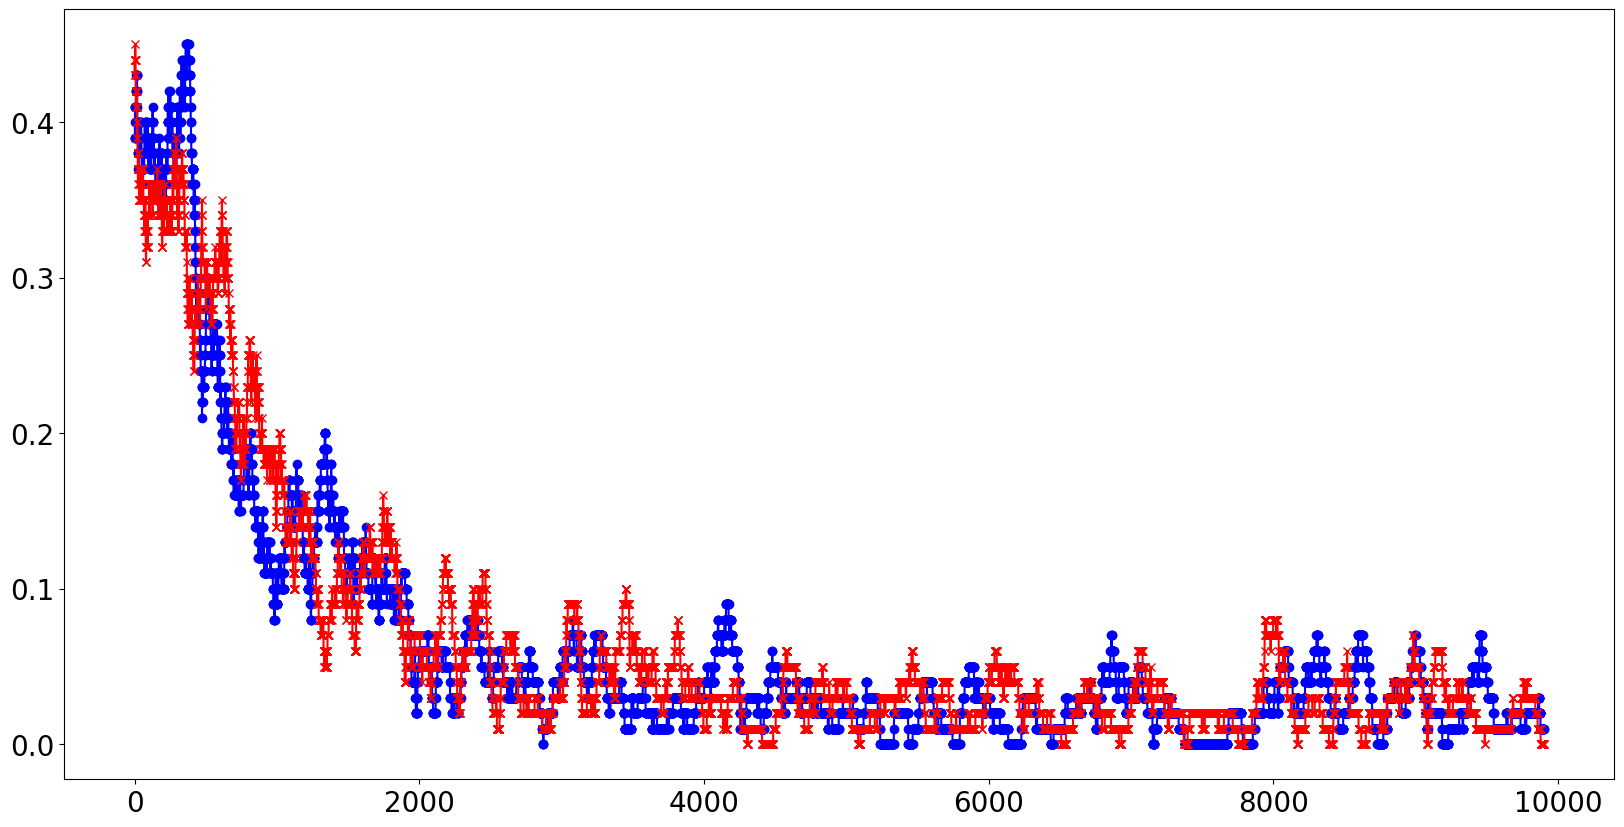

In [28]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams['font.size']=20
plt.plot(moving_average(np.array(actions)[:,0],100), label = 'Agent 1 Actions', marker = 'o', c = 'b')
plt.plot(moving_average(np.array(actions)[:,1],100), label = 'Agent 2 Actions', marker = 'x', c = 'r')
#plt.title('Fraction of Co-operations in 100 games') 
plt.show()

- Almost immediately the value of C is recognized
- Gradually both end up at (C,C)
- No discounting